# ASHRAE - Great Energy Predictor III

## Table of Contents <a id='back'></a>

* [1. Introduction](#intro)
* [2. Initiation](#init)
* [3. Data Validation and Cleaning](#overview)
	* [3.1. Train Set](#train)
	* [3.2. Test Set](#test)
	* [3.3. Weather](#weather)
	* [3.4. Building](#build)
	* [3.5. Merged Dataset](#merge)
* [4. Model Development](#dev)
	* [4.1. Feature Selection](#dev1)
	* [4.2. Preprocessing](#dev2)
	* [4.3. Build Model](#dev3)
    * [4.4. Features Evaluation](#dev4)
	* [4.5. Dimensionality Reduction](#dev5)
	* [4.6. Build Model with Reduced Features](#dev6)
* [5. General Conclusion](#end)
* [6. Submission](#submit)

## 1. Introduction <a id='intro'></a>

### 1.1. Background

Significant investments are being made to improve building efficiencies to reduce costs and emissions. So, are the improvements working? That’s where data scientist come in. 

Developing energy savings has two key elements: Forecasting future energy usage without improvements, and forecasting energy use after a specific set of improvements have been implemented. One issue preventing more aggressive growth of the energy markets are the lack of cost-effective, accurate, and scalable procedures for forecasting energy use.

In this project, the task is to develop accurate predictions of metered building energy usage in the following areas: chilled water, electric, natural gas, hot water, and steam meters. The data comes from over 1,000 buildings over a three-year timeframe.

With better estimates of these energy-saving investments, large scale investors and financial institutions will be more inclined to invest in this area to enable progress in building efficiencies. More accurate models could support better market incentives and enable lower cost financing.

### 1.2. Objectives

Build counterfactual models across four energy types based on historic usage rates and observed weather.<br>
The model will be evaluated using Root Mean Squared Logarithmic Error (RMSLE):

$$
\epsilon = \ln \sum{i} = \sqrt{1/n (\log(p_i + 1) - \log(a_i + 1))^2}
$$

Where:

- $\epsilon$ is the RMSLE value (score)
- n is the total number of observations in the (public/private) dataset
- pi is your prediction of the target
- ai is the actual target for i
- log(x) is the natural logarithm of x

Beberapa pertanyaan yang akan dijawab melalui penelitian ini:
1. Faktor apa yang paling berpengaruh terhadap penggunaan energi?
2. Apakah ada pengaruh faktor cuaca terhadap penggunaan energi? Apa ada faktor apa yang paling berpengaruh?
3. Apakah ada perbedaan penggunaan energi berdasarkan kegunaan bangunan?
4. Kapan saat-saat penggunaan energi paling besar? Kenapa demikian?
5. Bagaimana kita bisa membuat suatu model penghitung energi yang lebih prediktif?

### 1.3. Dataset Description

Data used can be found at this link: [Kaggle](https://www.kaggle.com/competitions/ashrae-energy-prediction/data)<br>
Data was collected by hourly meter readings for three years from over one thousand buildings at several locations worldwide.<br>
The dataset consists of 5 files with the following descriptions:

**train.csv**<br>
* `building_id` - Foreign key for the building metadata.
* `meter` - The meter id code. Read as `{0: electricity, 1: chilledwater, 2: steam, 3: hotwater}`. Not every building has all meter types.
* `timestamp` - When the measurement was taken
* `meter_reading` - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement  * error, which we expect will impose a baseline level of modeling error. UPDATE: as discussed [here](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/119261), the site 0 electric meter  * readings are in kBTU.

**building_meta.csv**<br>
* `site_id` - Foreign key for the weather files.
* `building_id` - Foreign key for training.csv
* `primary_use` - Indicator of the primary category of activities for the building based on [EnergyStar property type definitions](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/identify-your-property-type)
* `square_feet` - Gross floor area of the building
* `year_built` - Year building was opened
* `floor_count` - Number of floors of the building

**weather_[train/test].csv**<br>
Weather data from a meteorological station as close as possible to the site.

* `site_id`
* `air_temperature` - Degrees Celsius
* `cloud_coverage` - Portion of the sky covered in clouds, in [oktas](https://en.wikipedia.org/wiki/Okta)
* `dew_temperature` - Degrees Celsius
* `precip_depth_1_hr` - Millimeters
* `sea_level_pressure` - Millibar/hectopascals
* `wind_direction` - Compass direction (0-360)
* `wind_speed` - Meters per second

**test.csv**<br>
The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.

* `row_id` - Row id for your submission file
* `building_id` - Building id code
* `meter` - The meter id code
* `timestamp` - Timestamps for the test data period

### 1.4. Methodology
Steps taken for this research are:
1. Reducing dataset size
2. Data Cleaning
3. Exploratory Analysis
4. Model Development
5. Model Evaluation
6. Conclusion

[back to table of contents](#back)

## 2. Initiation <a id='init'></a>

### 2.1. Import Libraries

In [1]:
!pip install lightgbm

In [2]:
!pip install missingno

In [3]:
# Import necessary library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
import timeit
from datetime import date
import warnings

In [4]:
#set random seed for producibility
np.random.seed(0)

#ignore any warnings
warnings.filterwarnings("ignore")

### 2.2. Import Dataset

In [5]:
#import datasets
try:
    path = '/kaggle/input/ashrae-energy-prediction/'
    train = pd.read_csv(path + 'train.csv')
    test = pd.read_csv(path + 'test.csv')
    weather_train = pd.read_csv(path + 'weather_train.csv')
    weather_test = pd.read_csv(path + 'weather_test.csv')
    building = pd.read_csv(path + 'building_metadata.csv')
except:
    path = 'datasets/'
    train = pd.read_csv(path + 'train.csv')
    test = pd.read_csv(path + 'test.csv')
    weather_train = pd.read_csv(path + 'weather_train.csv')
    weather_test = pd.read_csv(path + 'weather_test.csv')
    building = pd.read_csv(path + 'building_metadata.csv')

### 2.3. Recalculate meter reading for building in site 0

Due to a miscommunication, the electric meter readings for site 0 were not properly converted to units of kWh and are in kBTU. The units of the **electric meter** readings for **site 0** will not be updated. For models that are sensitive to units/absolute values, the issue can be avoided with the right conversion factors. Multiply by 0.2931 to get to model inputs into kWh like the other sites, and 3.4118 to get back to kBTU for scoring.

In [6]:
#identify building ids in site 0
site_0_building_id = building[building['site_id'] == 0]['building_id'].unique()

#convert electric meter readings for site 0 from kBTU to kWh
train.loc[train['building_id'].isin(site_0_building_id) & train['meter'] == 0, 'meter_reading'] = train.loc[train['building_id'].isin(site_0_building_id) & train['meter'] == 0, 'meter_reading'] * 0.2931

### 2.4. Reduce Memory Usage

In [7]:
#Memory optimization
from pandas.api.types import is_datetime64_any_dtype
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime64_any_dtype(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    del start_mem, end_mem, col_type
    return df

In [8]:
# take random sample based on building id while maintaining all available dates and meter
def reduce_mem_usage_samp(df, col, n):
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    ids = pd.Series(df[col].unique()).sample(n=n, random_state=0)
    df = df[df[col].isin(ids)]
    
    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    print()
    del ids, start_mem, end_mem
    return df

In [9]:
# Reduce mem usage by dtypes
df_to_compress = {'train':train, 'test':test, 'weather_train':weather_train, 'weather_test':weather_test, 'building':building}
for name, df in df_to_compress.items():
    print('Compressing '+ name)
    df = reduce_mem_usage(df)
    print()

Compressing train
Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 289.19 MB
Decreased by 53.1%

Compressing test
Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 596.49 MB
Decreased by 53.1%

Compressing weather_train
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 3.07 MB
Decreased by 68.1%

Compressing weather_test
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 6.08 MB
Decreased by 68.1%

Compressing building
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.03 MB
Decreased by 60.3%



In [10]:
print('Train set shape = ', train.shape)
print('Test set shape = ', test.shape)
print('Number of building in train set = ', train['building_id'].nunique())
print('Number of building in test set = ', test['building_id'].nunique())

Train set shape =  (20216100, 4)
Test set shape =  (41697600, 4)
Number of building in train set =  1449
Number of building in test set =  1449


[Optional] Further reduce memory usage by sampling.

In [11]:
# Reduce mem usage by sampling
train = reduce_mem_usage_samp(train, 'building_id', 120)
test = reduce_mem_usage_samp(test, 'building_id', 120)

Memory usage of dataframe is 289.19 MB
Memory usage after optimization is: 36.53 MB
Decreased by 87.4%

Memory usage of dataframe is 596.49 MB
Memory usage after optimization is: 81.09 MB
Decreased by 86.4%



In [12]:
print('Train set shape = ', train.shape)
print('Test set shape = ', test.shape)
print('Number of building in train set = ', train['building_id'].nunique())
print('Number of building in test set = ', test['building_id'].nunique())

Train set shape =  (1665468, 4)
Test set shape =  (3696720, 4)
Number of building in train set =  120
Number of building in test set =  120


[back to table of contents](#back)

## 3. Data Validation and Cleaning <a id='overview'></a>

### 3.1. Train Set <a id='train'></a>

#### 3.1.1. Understanding Data

In [13]:
train.head()

building_id  meter            timestamp  meter_reading
4             4      0  2016-01-01 00:00:00            0.0
5             5      0  2016-01-01 00:00:00            0.0
9             9      0  2016-01-01 00:00:00            0.0
31           32      0  2016-01-01 00:00:00            0.0
34           35      0  2016-01-01 00:00:00            0.0

Meter reading for the first few observation equals to 0, we will explore this further after merging with other datasets.

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1665468 entries, 4 to 20216091
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   building_id    1665468 non-null  int16  
 1   meter          1665468 non-null  int8   
 2   timestamp      1665468 non-null  object 
 3   meter_reading  1665468 non-null  float32
dtypes: float32(1), int16(1), int8(1), object(1)
memory usage: 36.5+ MB


There are 1.6 million rows and 4 columns in this dataset. All the columns are in the right datatype except timestamp.

In [15]:
train.describe().T

count        mean         std  min         25%         50%  \
building_id    1665468.0  771.796170  446.162697  4.0  272.000000  888.000000   
meter          1665468.0    0.654569    0.920188  0.0    0.000000    0.000000   
meter_reading  1665468.0  118.811195  373.958496  0.0    5.267329   21.838031   

                       75%           max  
building_id    1177.000000   1441.000000  
meter             1.000000      3.000000  
meter_reading    77.774086  87919.445312

The disparity in the target column (meter reading) maximum and 75 percentile indicates that there are some outliers in this dataset.

In [16]:
train.duplicated().sum()

0

No duplicated rows.

In [17]:
train.isna().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

No missing values.

#### 3.1.2. Processing Data

Change `timestamp` to right datatype.

In [18]:
train['timestamp'] = pd.to_datetime(train['timestamp'])

Resample train set by date.

In [19]:
train = train.set_index('timestamp').sort_index().groupby(['building_id','meter'])['meter_reading'].resample('1D').sum().reset_index()

In [20]:
# Function to generate datetime features
def make_date_features(data, col):
    data['year'] = data[col].dt.year
    data['month'] = data[col].dt.month
    data['day'] = data[col].dt.day
    data['dayofweek'] = data[col].dt.dayofweek

Derive year, month, day, and day of week features from timestamp.

In [21]:
make_date_features(train, 'timestamp')

Derive meter reading rolling mean and standard deviation for meter reading per 24 days.

In [22]:
train['rolling_mean'] = train.set_index('timestamp').sort_index().groupby(['building_id','meter'])['meter_reading'].rolling(24).mean().values
train['rolling_std'] = train.set_index('timestamp').sort_index().groupby(['building_id','meter'])['meter_reading'].rolling(24).std().values

In [23]:
train.head(10)

building_id  meter  timestamp  meter_reading  year  month  day  dayofweek  \
0            4      0 2016-01-01            0.0  2016      1    1          4   
1            4      0 2016-01-02            0.0  2016      1    2          5   
2            4      0 2016-01-03            0.0  2016      1    3          6   
3            4      0 2016-01-04            0.0  2016      1    4          0   
4            4      0 2016-01-05            0.0  2016      1    5          1   
5            4      0 2016-01-06            0.0  2016      1    6          2   
6            4      0 2016-01-07            0.0  2016      1    7          3   
7            4      0 2016-01-08            0.0  2016      1    8          4   
8            4      0 2016-01-09            0.0  2016      1    9          5   
9            4      0 2016-01-10            0.0  2016      1   10          6   

   rolling_mean  rolling_std  
0           NaN          NaN  
1           NaN          NaN  
2           NaN          NaN  
3           NaN          NaN  
4           NaN          NaN  
5           NaN          NaN  
6           NaN          NaN  
7           NaN          NaN  
8           NaN          NaN  
9           NaN          NaN

#### 3.1.3. Plots and Removing Outliers

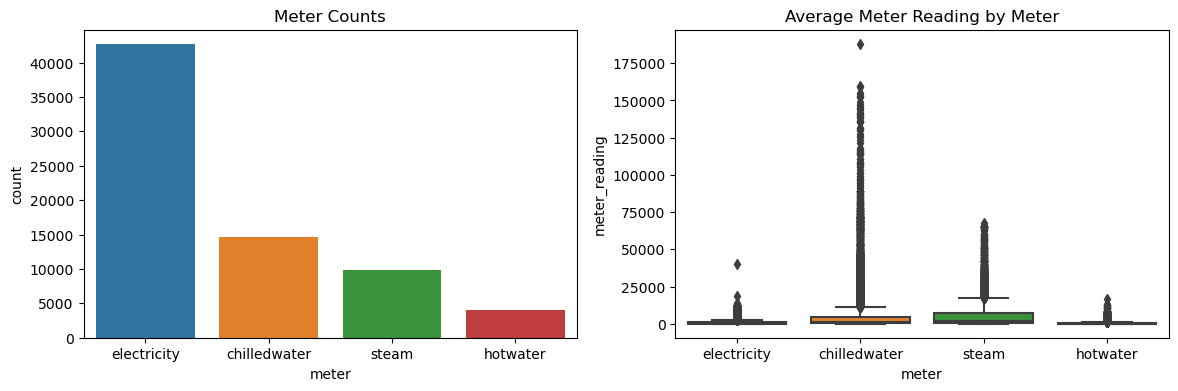

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4), sharey=False)
sns.countplot(data=train, x='meter', ax=ax[0]).set(title='Meter Counts')
sns.boxplot(data=train, x='meter', y='meter_reading', ax=ax[1]).set(title='Average Meter Reading by Meter')
ax[0].set_xticklabels(['electricity','chilledwater','steam','hotwater'])
ax[1].set_xticklabels(['electricity','chilledwater','steam','hotwater'])
plt.show()

The number of counts per meter from large to small is as follows: electricity > chilledwater > steam > hotwater. Counts in electricity meter is way more than the other counts this shows that not all building has chilled water, steam or hotwater meters installed.

Average meter reading per meter from large to small is as follows: chilledwater > steam > hotwater > electricity. Chilledwater and steam systems use way more energy than electricity and hotwater.

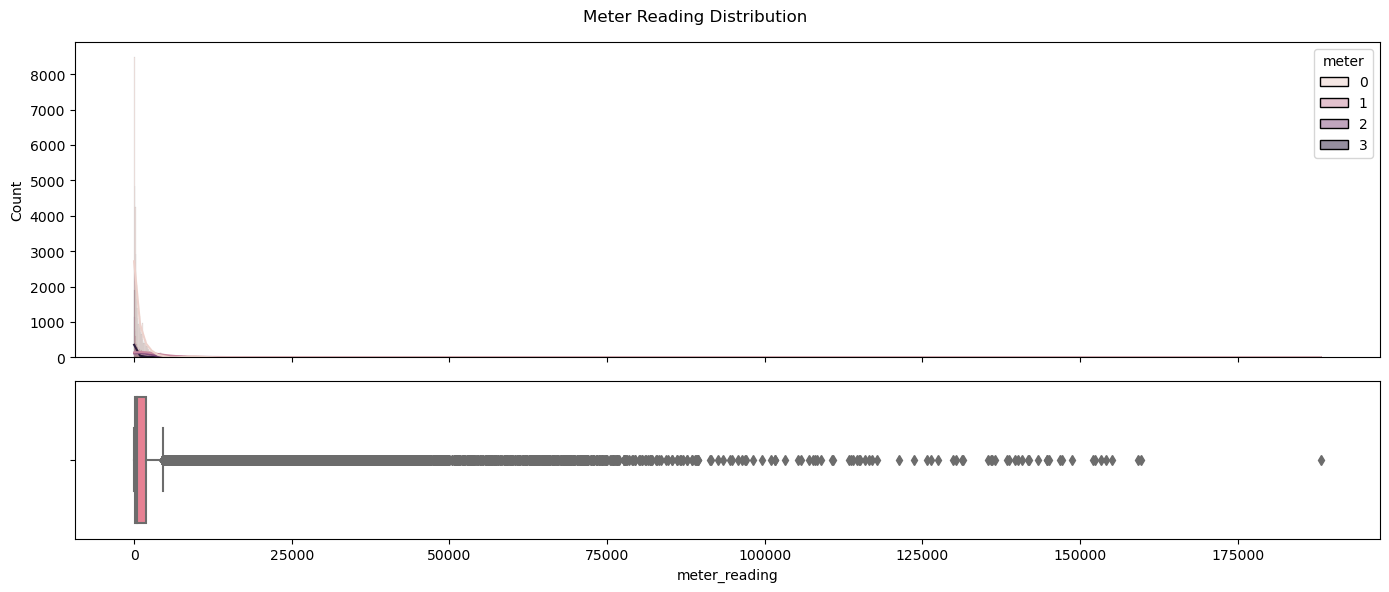

In [25]:
sns.set_palette('husl')
fig, ax = plt.subplots(2, 1, figsize=(14,6), sharex=True, gridspec_kw = {'height_ratios':[2, 1]})
sns.histplot(data=train, x='meter_reading', hue='meter', kde=True, ax=ax[0])
sns.boxplot(data=train, x='meter_reading', hue='meter', ax=ax[1])
plt.suptitle('Meter Reading Distribution')
plt.tight_layout()
plt.show()

In [26]:
sns.set_palette('husl')
plt.figure(figsize=(14,4))
sns.histplot(data=train, x='meter_reading', hue='meter', alpha=0.7, kde=True, ax=ax[0]).set(xlim=[0,10000])
plt.suptitle('Meter Reading Distribution')
plt.tight_layout()
plt.show()

<Figure size 1400x400 with 0 Axes>

Distribution for meter reading is right-skewed. There are many outliers.

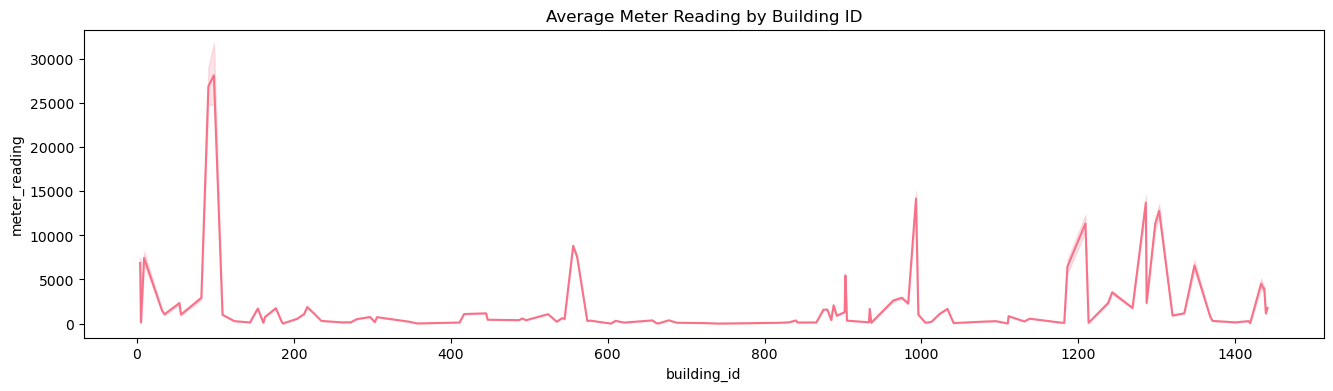

In [27]:
plt.figure(figsize=(16,4))
sns.lineplot(data=train, x='building_id', y='meter_reading')
plt.title('Average Meter Reading by Building ID')
plt.show()

There are some building with average meter reading far higher than the others.

Remove outliers:

In [28]:
filter = pd.DataFrame(train.groupby('building_id')['meter_reading'].mean() > 20000)

In [29]:
train = train[~train['building_id'].isin(filter[filter.values == True].index)]

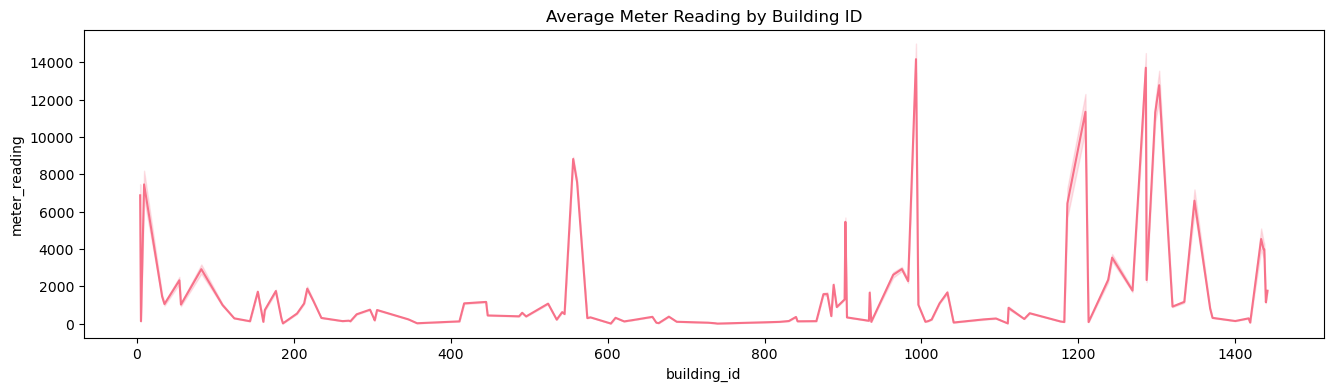

In [30]:
plt.figure(figsize=(16,4))
sns.lineplot(data=train, x='building_id', y='meter_reading')
plt.title('Average Meter Reading by Building ID')
plt.show()

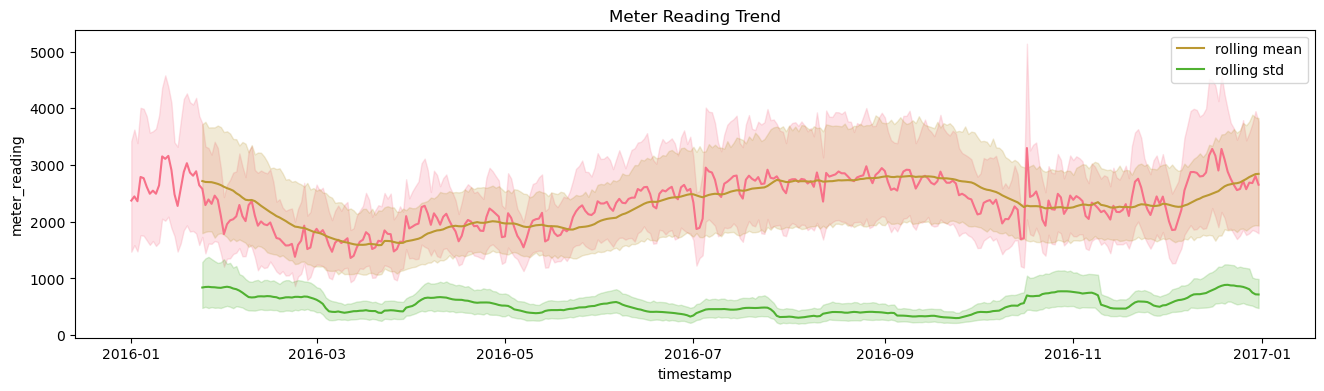

In [31]:
plt.figure(figsize=(16,4))
sns.lineplot(data=train, x='timestamp', y='meter_reading')
sns.lineplot(data=train, x='timestamp', y='rolling_mean', label='rolling mean')
sns.lineplot(data=train, x='timestamp', y='rolling_std', label='rolling std')
plt.title('Meter Reading Trend')
plt.show()

Meter reading shows an upward trend from March to September and downward trend from January to March.

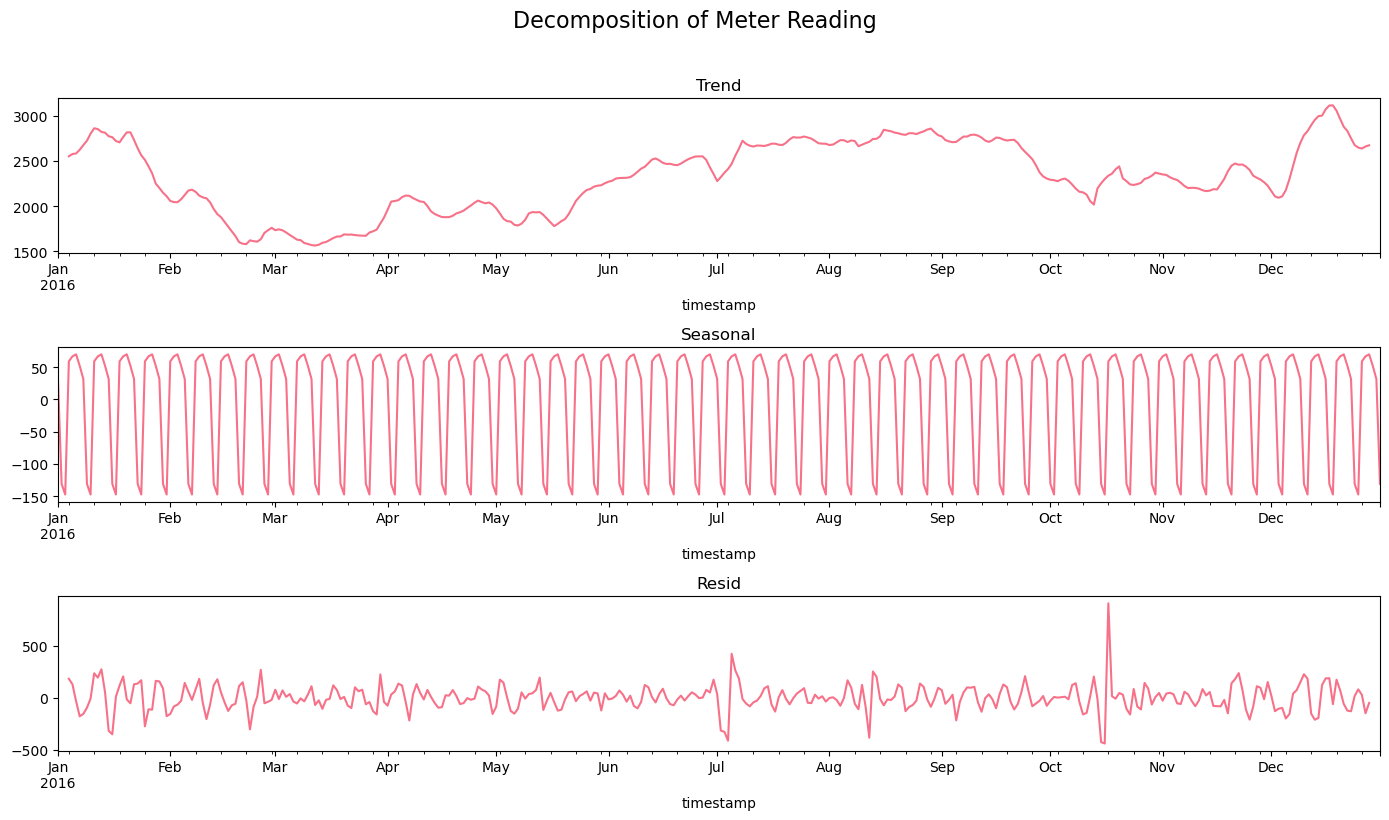

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(train.groupby('timestamp')['meter_reading'].mean())

plt.figure(figsize=(14,8))
plt.suptitle('Decomposition of Meter Reading', y=1.02, fontsize=16, fontweight=400)

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Resid')
plt.tight_layout()

There is a recurring (seasonal) trend each week.

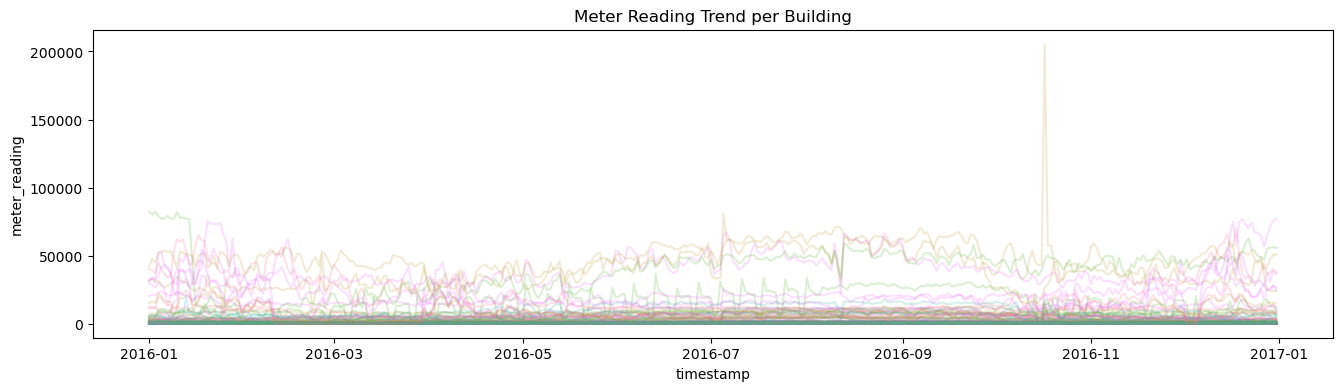

In [33]:
plt.figure(figsize=(16,4))
for id in train['building_id'].unique():
    train_by_id = train[train['building_id']==id].groupby('timestamp')['meter_reading'].sum().reset_index()
    sns.lineplot(data=train_by_id, x='timestamp', y='meter_reading', alpha=0.2)
plt.title('Meter Reading Trend per Building')
plt.show()

One of the building shows a high reading on mid october.

Outlier = 993


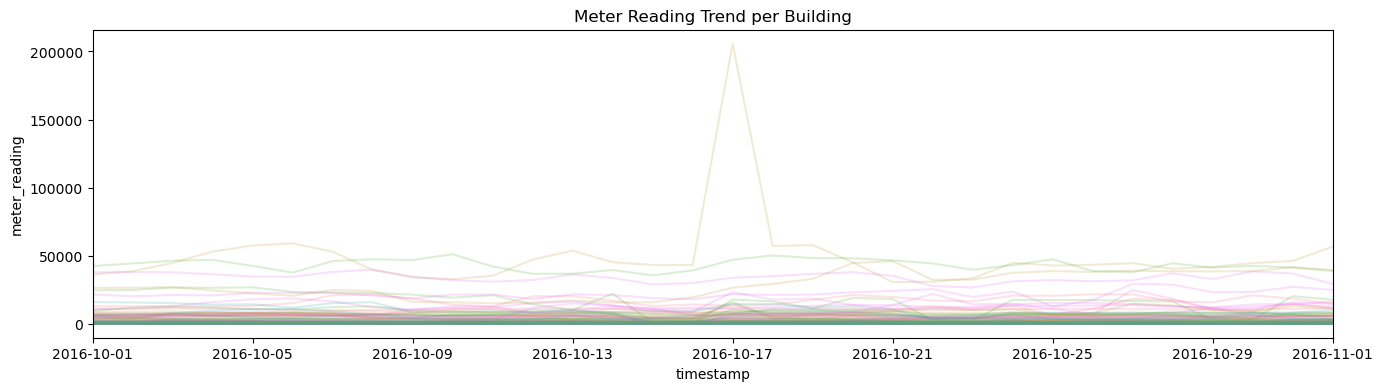

In [34]:
plt.figure(figsize=(16,4))
for id in train['building_id'].unique():
    train_by_id = train[train['building_id']==id].groupby('timestamp')['meter_reading'].sum().reset_index()
    if train_by_id[train_by_id['timestamp'] == '2016-10-17']['meter_reading'].sum() > 150000:
        print('Outlier =', id)    
    sns.lineplot(data=train_by_id, x='timestamp', y='meter_reading', alpha=0.2)
plt.xlim([date(2016,10,1),date(2016,11,1)])
plt.title('Meter Reading Trend per Building')
plt.show()

Delete outlier building:

In [35]:
train = train[train['building_id'] != 993]

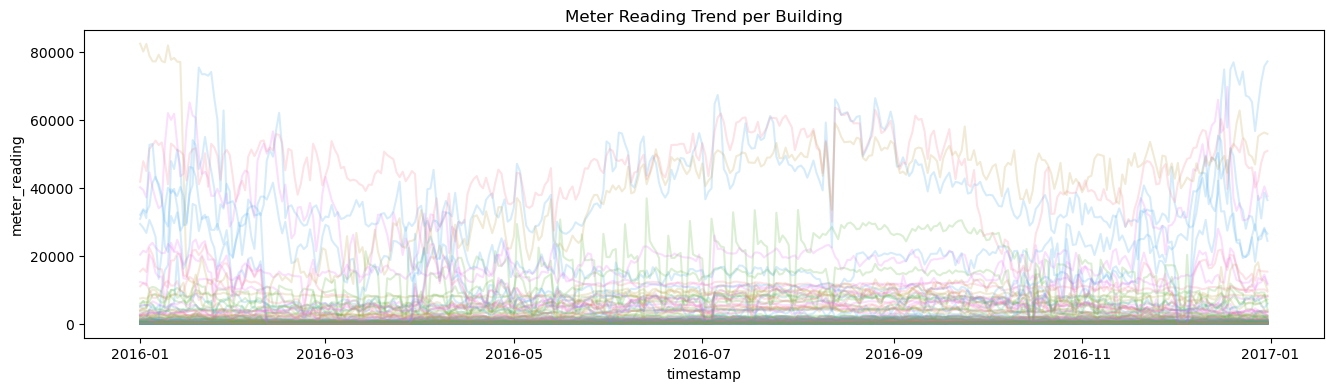

In [36]:
plt.figure(figsize=(16,4))
for id in train['building_id'].unique():
    train_by_id = train[train['building_id']==id].groupby('timestamp')['meter_reading'].sum().reset_index()
    sns.lineplot(data=train_by_id, x='timestamp', y='meter_reading', alpha=0.2)
plt.title('Meter Reading Trend per Building')
plt.show()

[back to table of contents](#back)

### 3.2. Test Set <a id='test'></a>

#### 3.2.1. Understanding Data

In [37]:
test.head()

row_id  building_id  meter            timestamp
4        4            4      0  2017-01-01 00:00:00
5        5            5      0  2017-01-01 00:00:00
10      10            9      0  2017-01-01 00:00:00
11      11            9      1  2017-01-01 00:00:00
39      39           31      0  2017-01-01 00:00:00

In [38]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3696720 entries, 4 to 41697596
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   row_id       int32 
 1   building_id  int16 
 2   meter        int8  
 3   timestamp    object
dtypes: int16(1), int32(1), int8(1), object(1)
memory usage: 81.1+ MB


`timestamp` is in the wrong datatype.

In [39]:
test.describe().T

count          mean           std  min         25%  \
row_id       3696720.0  2.117191e+07  1.212559e+07  4.0  10383987.5   
building_id  3696720.0  8.245024e+02  4.386187e+02  4.0       413.0   
meter        3696720.0  6.966825e-01  9.199931e-01  0.0         0.0   

                    50%         75%         max  
row_id       21698144.0  31432519.5  41697596.0  
building_id       914.0      1215.0      1445.0  
meter               0.0         1.0         3.0

No weird statistics.

In [40]:
test.duplicated().sum()

0

No duplicated rows.

In [41]:
test.isna().sum()

row_id         0
building_id    0
meter          0
timestamp      0
dtype: int64

No missing values.

#### 3.2.2. Processing Data

Change `timestamp` to right datatype.

In [42]:
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [43]:
make_date_features(test, 'timestamp')

#### 3.2.3. Plots

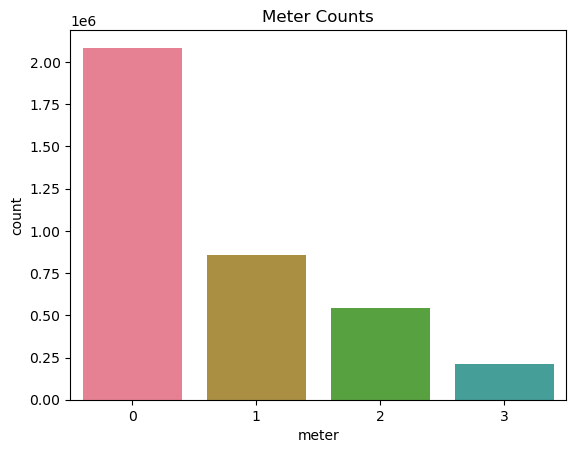

In [44]:
sns.countplot(data=test, x='meter')
plt.title('Meter Counts')
plt.show()

Meter counts are similar with train set counts.

[back to table of contents](#back)

### 3.3. Weather Data <a id='weather'></a>

#### 3.3.1. Understanding Data

##### 3.3.1.1. Train Data

In [45]:
weather_train.head()

site_id            timestamp  air_temperature  cloud_coverage  \
0        0  2016-01-01 00:00:00        25.000000             6.0   
1        0  2016-01-01 01:00:00        24.406250             NaN   
2        0  2016-01-01 02:00:00        22.796875             2.0   
3        0  2016-01-01 03:00:00        21.093750             2.0   
4        0  2016-01-01 04:00:00        20.000000             2.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0         20.00000                NaN              1019.5             0.0   
1         21.09375               -1.0              1020.0            70.0   
2         21.09375                0.0              1020.0             0.0   
3         20.59375                0.0              1020.0             0.0   
4         20.00000               -1.0              1020.0           250.0   

   wind_speed  
0    0.000000  
1    1.500000  
2    0.000000  
3    0.000000  
4    2.599609

In [46]:
weather_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int8   
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float16
 3   cloud_coverage      70600 non-null   float16
 4   dew_temperature     139660 non-null  float16
 5   precip_depth_1_hr   89484 non-null   float16
 6   sea_level_pressure  129155 non-null  float16
 7   wind_direction      133505 non-null  float16
 8   wind_speed          139469 non-null  float16
dtypes: float16(7), int8(1), object(1)
memory usage: 3.1+ MB


Timestamp is in the wrong datatype.

Change `timestamp` to right datatype.

In [47]:
weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp'])

In [48]:
weather_train['date'] = pd.to_datetime(weather_train['timestamp'].dt.date)

In [49]:
weather_train.describe().T

count      mean       std        min          25%  \
site_id             139773.0  7.478977  4.604744    0.00000     3.000000   
air_temperature     139718.0       NaN  0.000000  -28.90625     7.199219   
cloud_coverage       70600.0       NaN  0.000000    0.00000     0.000000   
dew_temperature     139660.0       NaN  0.000000  -35.00000     0.600098   
precip_depth_1_hr    89484.0       NaN       NaN   -1.00000     0.000000   
sea_level_pressure  129155.0       NaN       NaN  968.00000  1012.000000   
wind_direction      133505.0       NaN       NaN    0.00000    80.000000   
wind_speed          139469.0       NaN  0.000000    0.00000     2.099609   

                            50%          75%         max  
site_id                7.000000    11.000000    15.00000  
air_temperature       15.000000    22.203125    47.18750  
cloud_coverage         2.000000     4.000000     9.00000  
dew_temperature        8.296875    14.398438    26.09375  
precip_depth_1_hr      0.000000     0.000000   343.00000  
sea_level_pressure  1016.500000  1021.000000  1046.00000  
wind_direction       190.000000   280.000000   360.00000  
wind_speed             3.099609     5.000000    19.00000

The features are in acceptable ranges.

In [50]:
weather_train.duplicated().sum()

0

No duplicated rows.

In [51]:
weather_train.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
date                      0
dtype: int64

A lot of missing values especially in cloud coverage and precipitation depth.

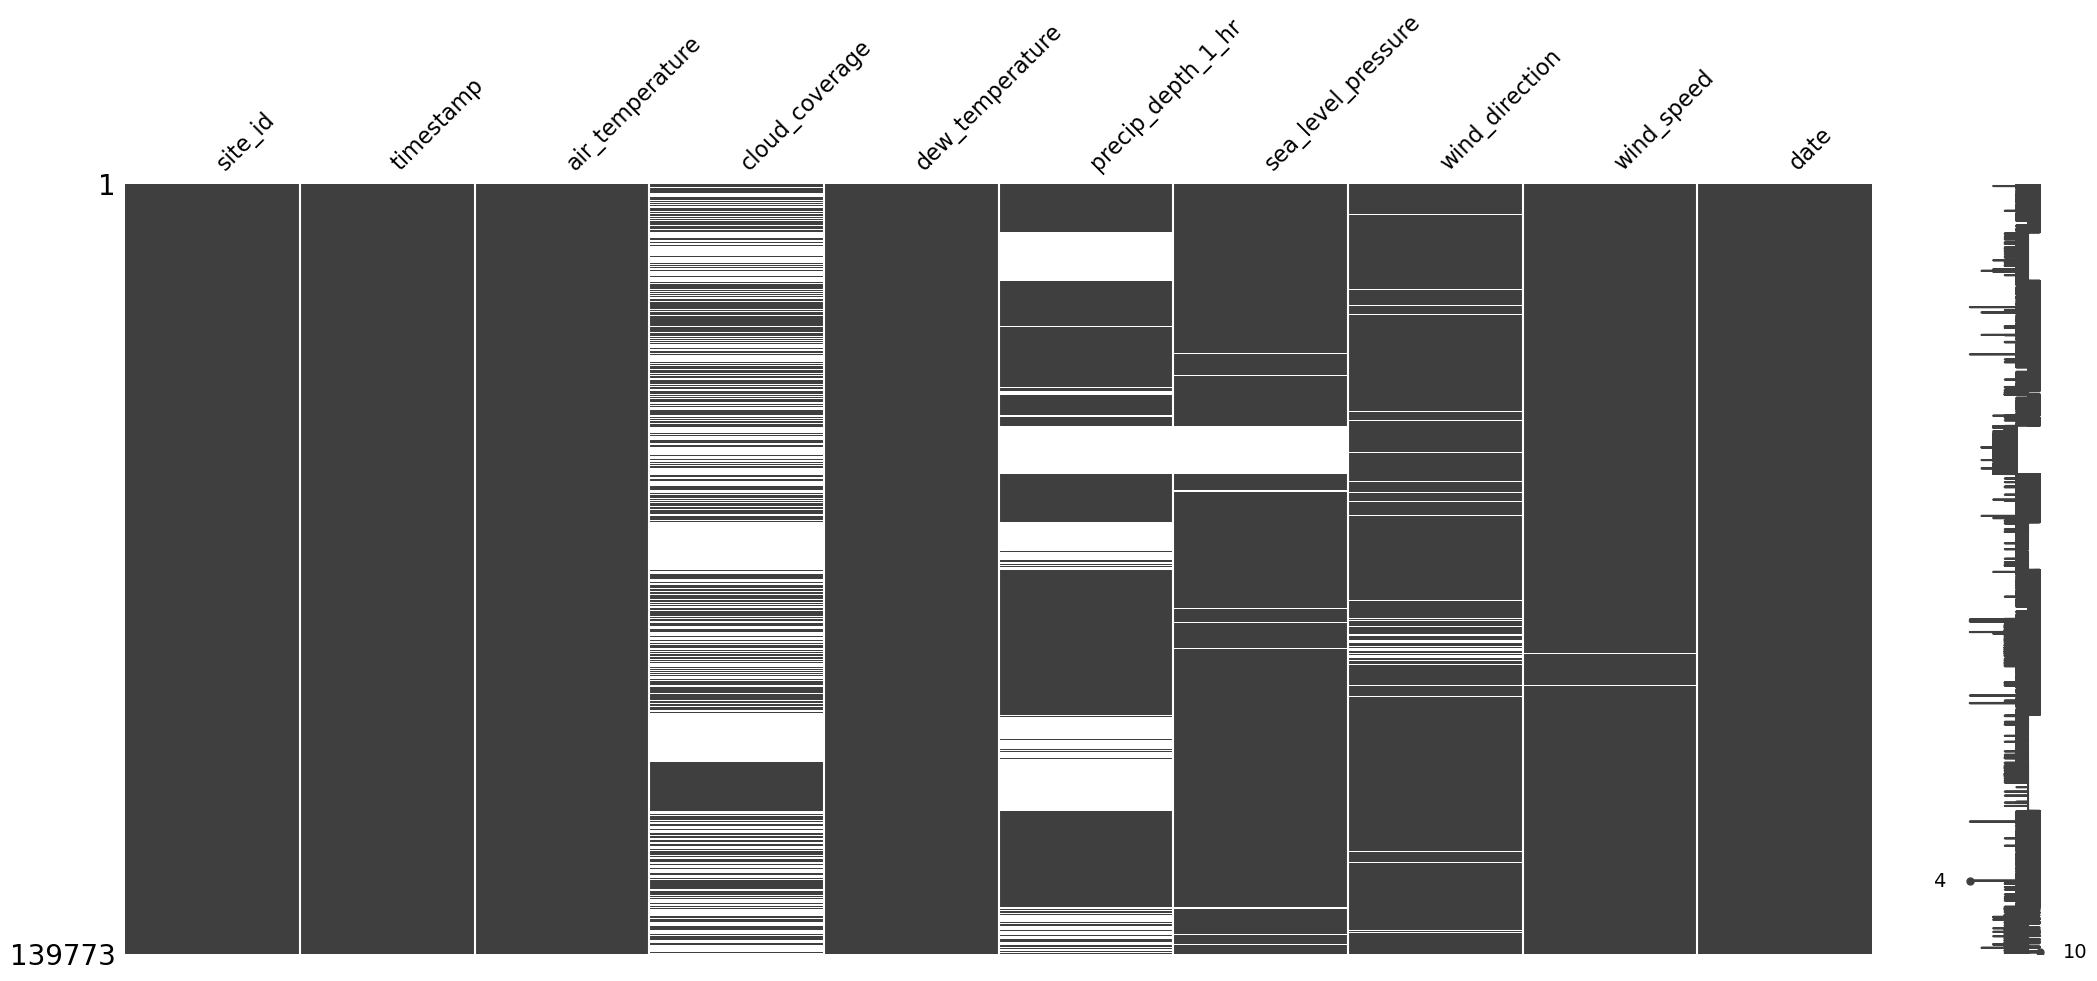

In [52]:
msno.matrix(weather_train.sort_values(by=['site_id','timestamp']))
plt.show()

Missing values in block indicates that several areas don't have those measurements.

##### 3.3.1.1. Test Data

In [53]:
weather_test.head()

site_id            timestamp  air_temperature  cloud_coverage  \
0        0  2017-01-01 00:00:00        17.796875             4.0   
1        0  2017-01-01 01:00:00        17.796875             2.0   
2        0  2017-01-01 02:00:00        16.093750             0.0   
3        0  2017-01-01 03:00:00        17.203125             0.0   
4        0  2017-01-01 04:00:00        16.703125             2.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0        11.703125                NaN              1021.5           100.0   
1        12.796875                0.0              1022.0           130.0   
2        12.796875                0.0              1022.0           140.0   
3        13.296875                0.0              1022.0           140.0   
4        13.296875                0.0              1022.5           130.0   

   wind_speed  
0    3.599609  
1    3.099609  
2    3.099609  
3    3.099609  
4    2.599609

In [54]:
weather_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             277243 non-null  int8   
 1   timestamp           277243 non-null  object 
 2   air_temperature     277139 non-null  float16
 3   cloud_coverage      136795 non-null  float16
 4   dew_temperature     276916 non-null  float16
 5   precip_depth_1_hr   181655 non-null  float16
 6   sea_level_pressure  255978 non-null  float16
 7   wind_direction      264873 non-null  float16
 8   wind_speed          276783 non-null  float16
dtypes: float16(7), int8(1), object(1)
memory usage: 6.1+ MB


Timestamp is in the wrong datatype.

Change `timestamp` to right datatype.

In [55]:
weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp'])

In [56]:
weather_test['date'] = pd.to_datetime(weather_test['timestamp'].dt.date)

In [57]:
weather_test.describe().T

count      mean       std        min          25%  \
site_id             277243.0  7.484654  4.616959    0.00000     3.000000   
air_temperature     277139.0       NaN  0.000000  -28.09375     7.199219   
cloud_coverage      136795.0       NaN  0.000000    0.00000     0.000000   
dew_temperature     276916.0       NaN  0.000000  -31.59375     0.600098   
precip_depth_1_hr   181655.0       NaN       NaN   -1.00000     0.000000   
sea_level_pressure  255978.0       NaN       NaN  972.00000  1011.500000   
wind_direction      264873.0       NaN       NaN    0.00000    80.000000   
wind_speed          276783.0       NaN  0.000000    0.00000     2.099609   

                            50%          75%          max  
site_id                7.000000    12.000000    15.000000  
air_temperature       15.000000    22.203125    48.312500  
cloud_coverage         2.000000     4.000000     9.000000  
dew_temperature        8.398438    15.000000    26.703125  
precip_depth_1_hr      0.000000     0.000000   597.000000  
sea_level_pressure  1016.500000  1021.000000  1050.000000  
wind_direction       190.000000   280.000000   360.000000  
wind_speed             3.099609     4.601562    24.203125

The features are in acceptable ranges.

In [58]:
weather_test.duplicated().sum()

0

No duplicated rows.

In [59]:
weather_test.isna().sum()

site_id                    0
timestamp                  0
air_temperature          104
cloud_coverage        140448
dew_temperature          327
precip_depth_1_hr      95588
sea_level_pressure     21265
wind_direction         12370
wind_speed               460
date                       0
dtype: int64

A lot of missing values especially in cloud coverage and precipitation depth.

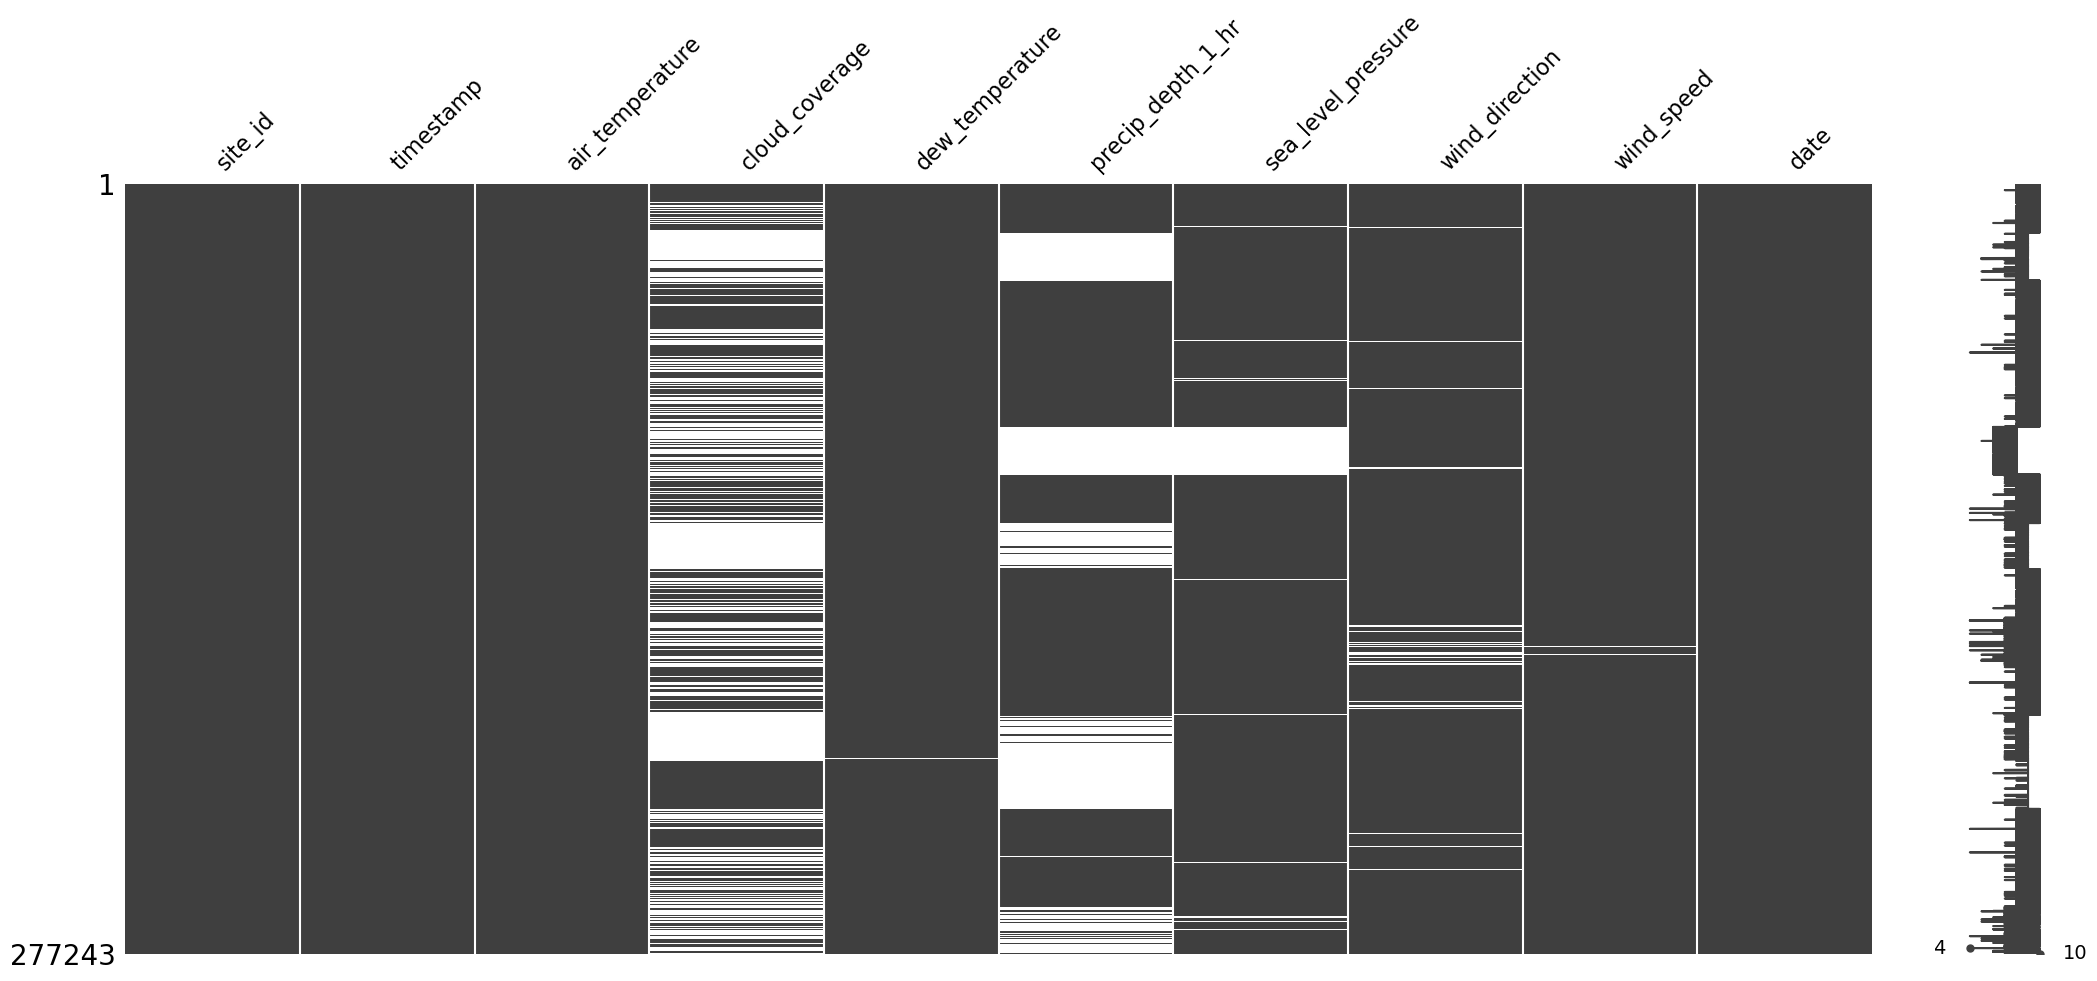

In [60]:
msno.matrix(weather_test.sort_values(by=['site_id','timestamp']))
plt.show()

Missing values in block indicates that several areas don't have those measurements.

#### 3.3.2. Combine Data

In [61]:
weather_train['set'] = 'train'
weather_test['set'] = 'test'

In [62]:
weather = pd.concat([weather_train, weather_test], axis=0)

Change `timestamp` to right datatype.

In [63]:
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

In [64]:
weather['date'] = pd.to_datetime(weather['date'])

In [65]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417016 entries, 0 to 277242
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             417016 non-null  int8          
 1   timestamp           417016 non-null  datetime64[ns]
 2   air_temperature     416857 non-null  float16       
 3   cloud_coverage      207395 non-null  float16       
 4   dew_temperature     416576 non-null  float16       
 5   precip_depth_1_hr   271139 non-null  float16       
 6   sea_level_pressure  385133 non-null  float16       
 7   wind_direction      398378 non-null  float16       
 8   wind_speed          416252 non-null  float16       
 9   date                417016 non-null  datetime64[ns]
 10  set                 417016 non-null  object        
dtypes: datetime64[ns](2), float16(7), int8(1), object(1)
memory usage: 18.7+ MB


Resample all the weather data by date.

In [66]:
weather_1d = weather.set_index('timestamp').sort_index() \
                   .groupby('site_id')['air_temperature', 'cloud_coverage','dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed'] \
                   .resample('1D').mean().reset_index()

Merge original data with resampled data so that both original and resampled data can be plotted.

In [67]:
weather_plus1 = weather.merge(weather_1d, left_on=['date','site_id'], right_on=['timestamp','site_id'], how='left', suffixes=['','_1d'])

[back to table of contents](#back)

#### 3.3.3. Explore Data

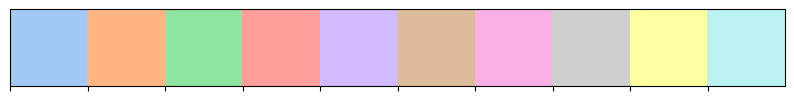

In [68]:
pal = sns.color_palette('pastel')
sns.palplot(pal)

##### 3.3.3.1. Air Temperature

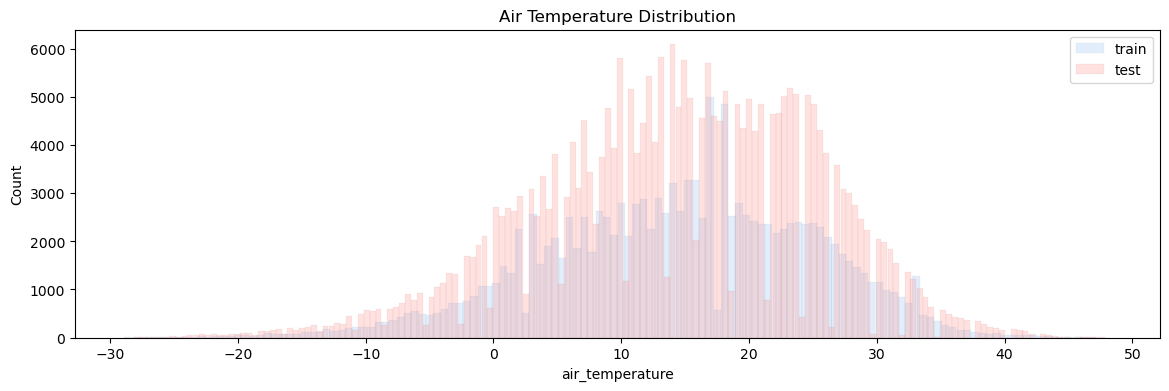

In [69]:
plt.figure(figsize=(14,4))
sns.histplot(data=weather_train, x='air_temperature', color=pal[0], kde=True, alpha=0.3, linewidth=0.02, label='train')
sns.histplot(data=weather_test, x='air_temperature', color=pal[3], kde=True, alpha=0.3, linewidth=0.02, label='test')
plt.title('Air Temperature Distribution')
plt.legend()
plt.show()

Typical air temperature ranges from $10^{\circ}C$ to $25^{\circ}C$.

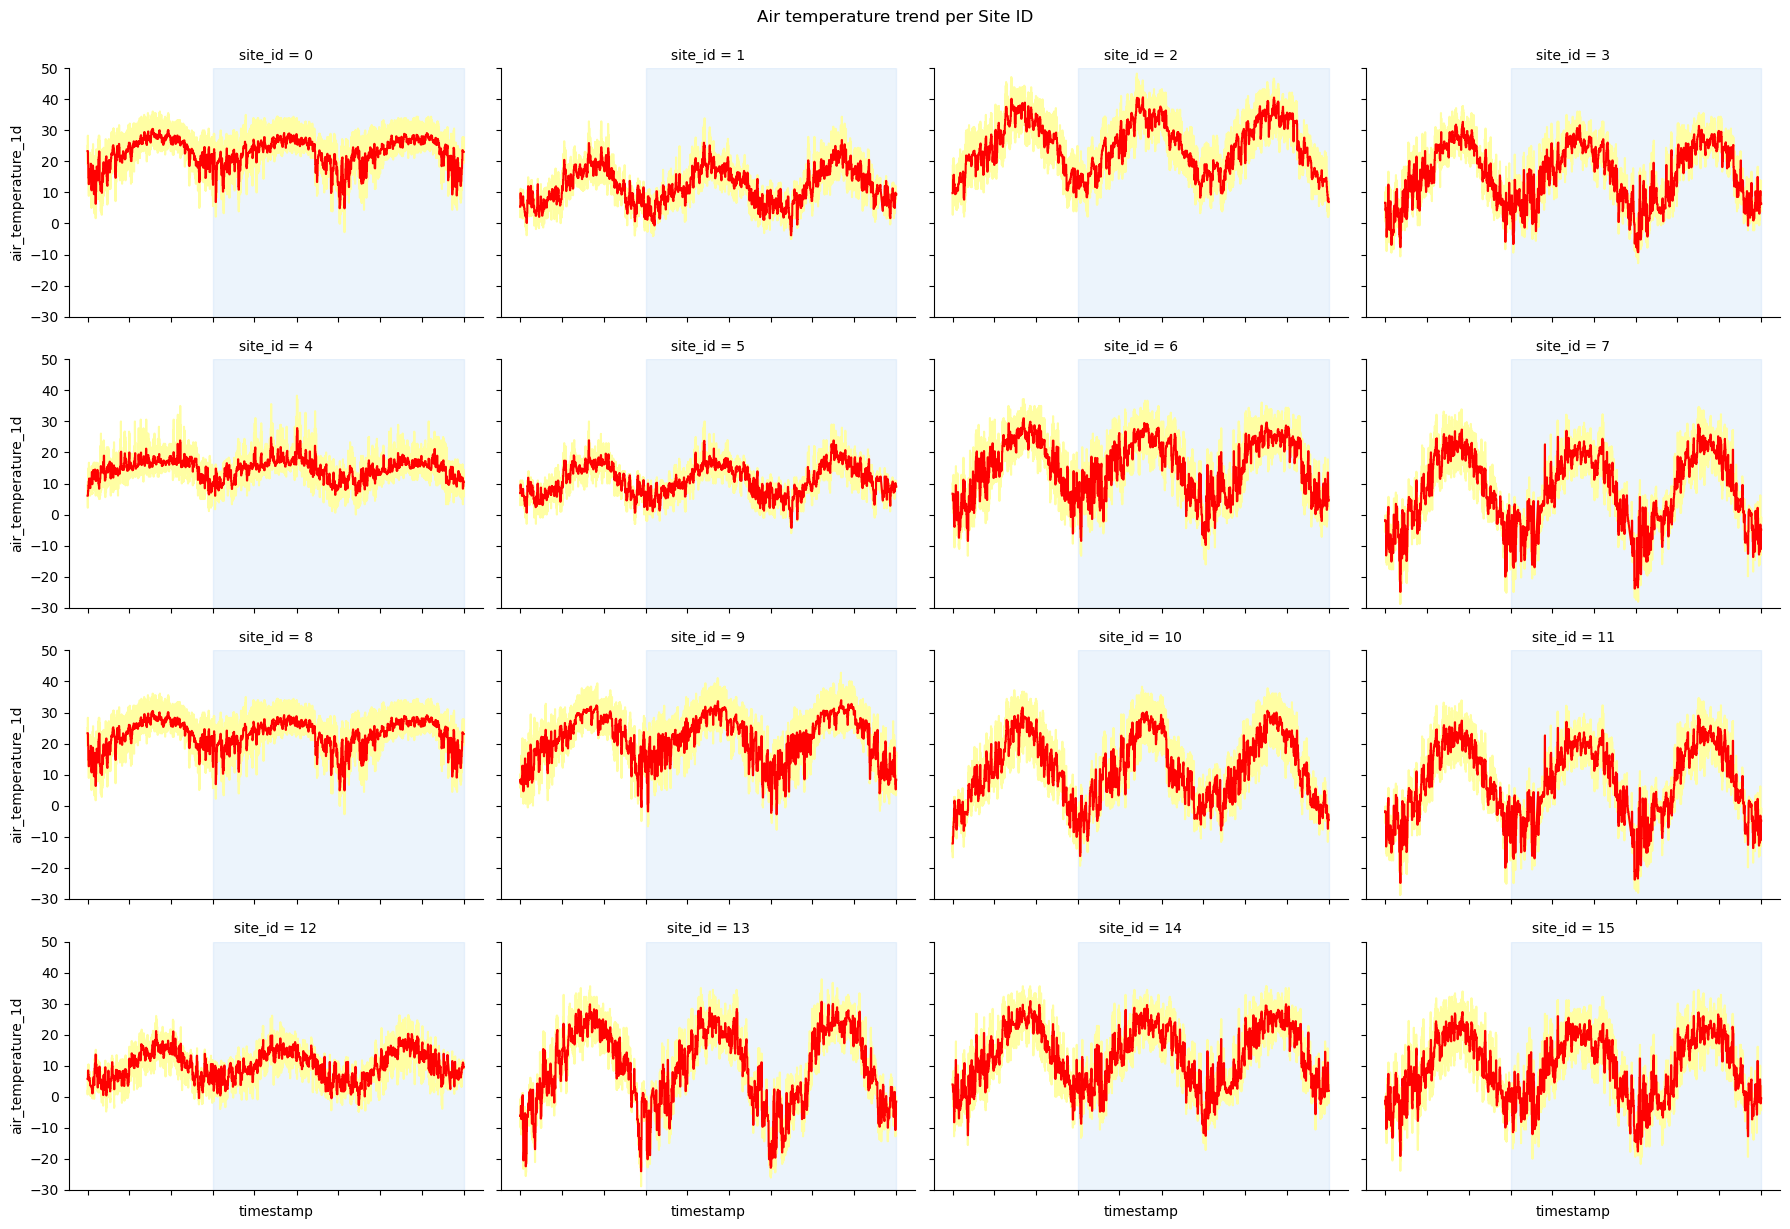

In [70]:
sns.set_palette('pastel')
grid = sns.FacetGrid(weather_plus1, col="site_id", col_wrap=4, height=3, aspect=1.5, sharex=True, sharey=True)
grid.map(plt.axvspan, xmin=weather_test['timestamp'].min(), xmax=weather_test['timestamp'].max(), facecolor='green', alpha=0.2)
grid.map_dataframe(plt.plot, 'timestamp', 'air_temperature', color=pal[-2], alpha=1)
grid.map_dataframe(plt.plot, 'timestamp', 'air_temperature_1d', color='red', alpha=1)
grid.set(ylim=(-30,50))
grid.set_xticklabels(rotation=45)

grid.fig.tight_layout(w_pad=1)
plt.suptitle('Air temperature trend per Site ID', y=1.02)
plt.show()

Some of the sites have more fluctuations than the other site. Maybe some sites like site 1, 4, 5, 12 are closer to the equator than the others.

##### 3.3.3.2. Cloud Coverage

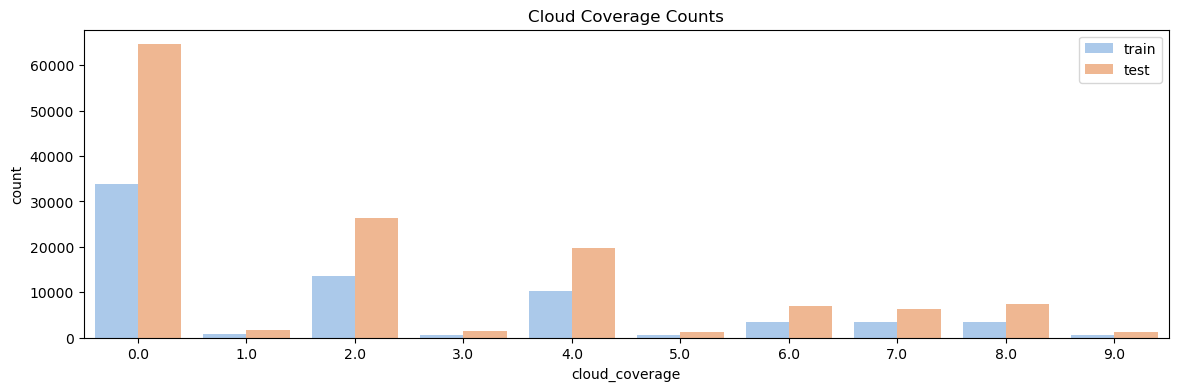

In [71]:
sns.set_palette('pastel')
plt.figure(figsize=(14,4))
sns.countplot(data=weather_plus1, x='cloud_coverage', hue='set')
plt.title('Cloud Coverage Counts')
plt.legend()
plt.show()

Cloud coverage counts are pretty similar in both datasets.

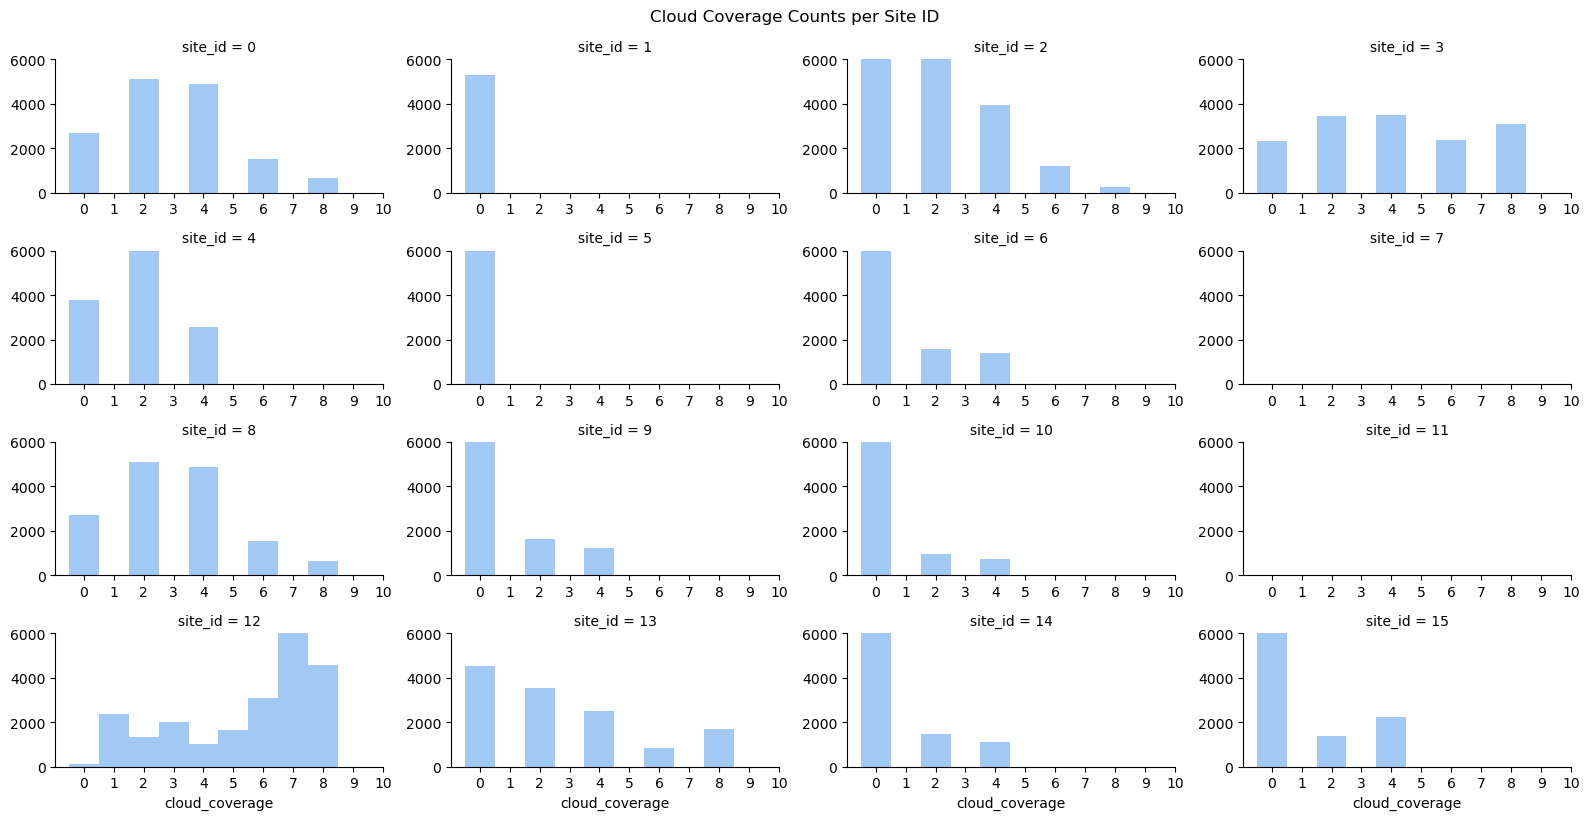

In [72]:
grid = sns.FacetGrid(weather_plus1, col="site_id", col_wrap=4, height=2, aspect=2, sharex=False, sharey=False)
grid.map_dataframe(plt.hist, x='cloud_coverage', bins = np.arange(10) - 0.5)
grid.set(xticks=range(11), xticklabels=range(11), ylim=(0,6000))
grid.fig.tight_layout(w_pad=1)
plt.suptitle('Cloud Coverage Counts per Site ID', y=1.02)
plt.show()

Site 7 and 11 don't have any measurement for cloud coverage. Maybe these sites don't have any measuring device installed for this measurement.<br>
Site 1, and 5 has 0 cloud coverage. Maybe the measurement for this site is off.<br>
Site 0, 2, and 8 have pretty similar cloud coverage.<br>
Site 6, 9, 10, 14, and 15 also have pretty similar cloud coverage.<br>
Site 12 is mostly covered by clouds.

Overall, the variance in this feature is pretty variable. This should be a good feature for prediction.

##### 3.3.3.3. Dew Temperature

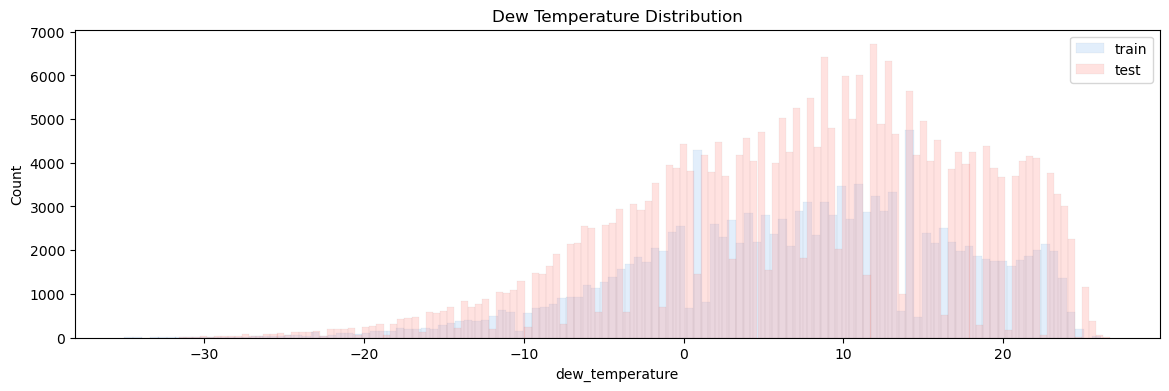

In [73]:
plt.figure(figsize=(14,4))
sns.histplot(data=weather_train, x='dew_temperature', color=pal[0], kde=True, alpha=0.3, linewidth=0.02, label='train')
sns.histplot(data=weather_test, x='dew_temperature', color=pal[3], kde=True, alpha=0.3, linewidth=0.02, label='test')
plt.title('Dew Temperature Distribution')
plt.legend()
plt.show()

Typical dew temperature ranges from $5^{\circ}C$ to $15^{\circ}C$.

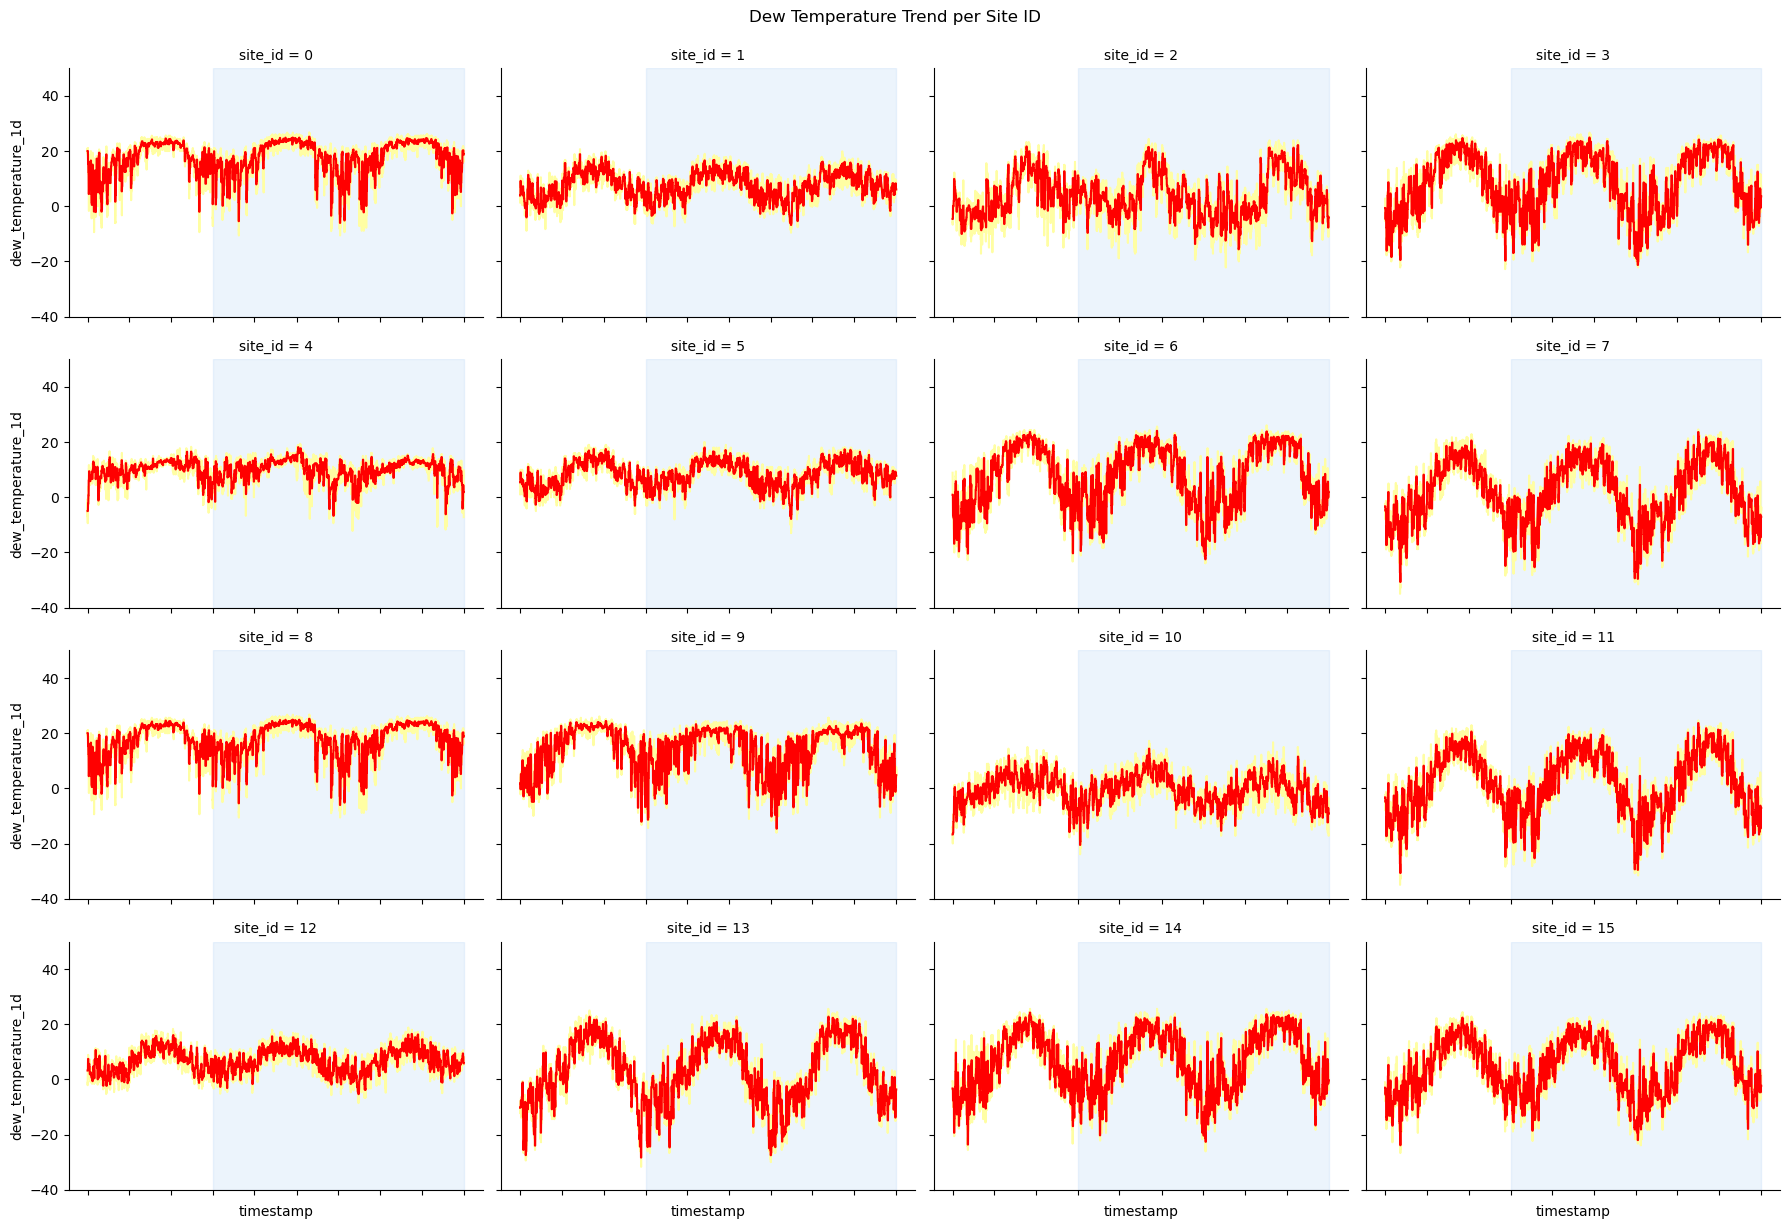

In [74]:
grid = sns.FacetGrid(weather_plus1, col="site_id", col_wrap=4, height=3, aspect=1.5, sharex=True, sharey=True)
grid.map(plt.axvspan, xmin=weather_test['timestamp'].min(), xmax=weather_test['timestamp'].max(), facecolor='green', alpha=0.2)
grid.map_dataframe(plt.plot, 'timestamp', 'dew_temperature', color=pal[-2], alpha=1)
grid.map_dataframe(plt.plot, 'timestamp', 'dew_temperature_1d', color='red', alpha=1)
grid.set(ylim=(-40,50))
grid.set_xticklabels(rotation=45)
grid.fig.tight_layout(w_pad=1)
plt.suptitle('Dew Temperature Trend per Site ID', y=1.02)
plt.show()

This feature has the same pattern with air temperature.<br>
Some of the sites have more fluctuations in dew temperature than the other site. Maybe some sites like site 1, 4, 5, 12 are closer to the equator than the others.

##### 3.3.3.4. Precipitation Depth

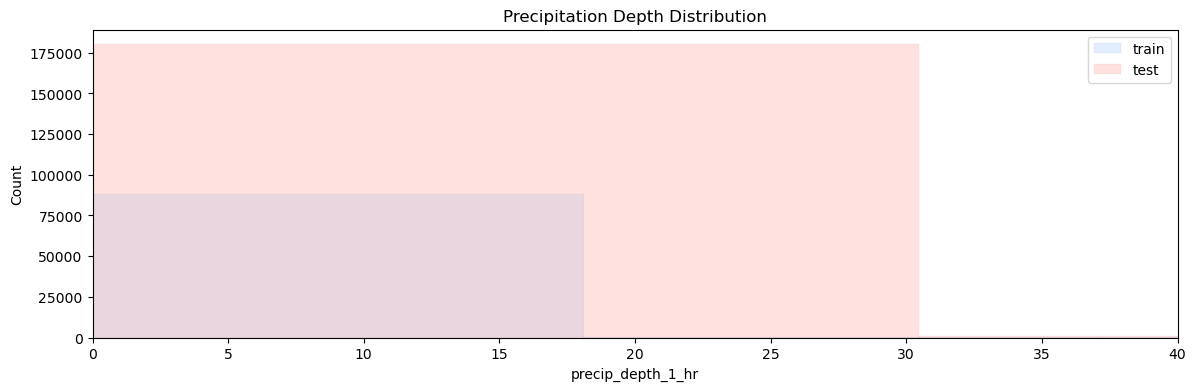

In [75]:
plt.figure(figsize=(14,4))
sns.histplot(data=weather_train, x='precip_depth_1_hr', color=pal[0], kde=True, alpha=0.3, linewidth=0.02, label='train')
sns.histplot(data=weather_test, x='precip_depth_1_hr', color=pal[3], kde=True, alpha=0.3, linewidth=0.02, label='test')
plt.title('Precipitation Depth Distribution')
plt.xlim([0,40])
plt.legend()
plt.show()

Precipitation depths are low in both datasets.

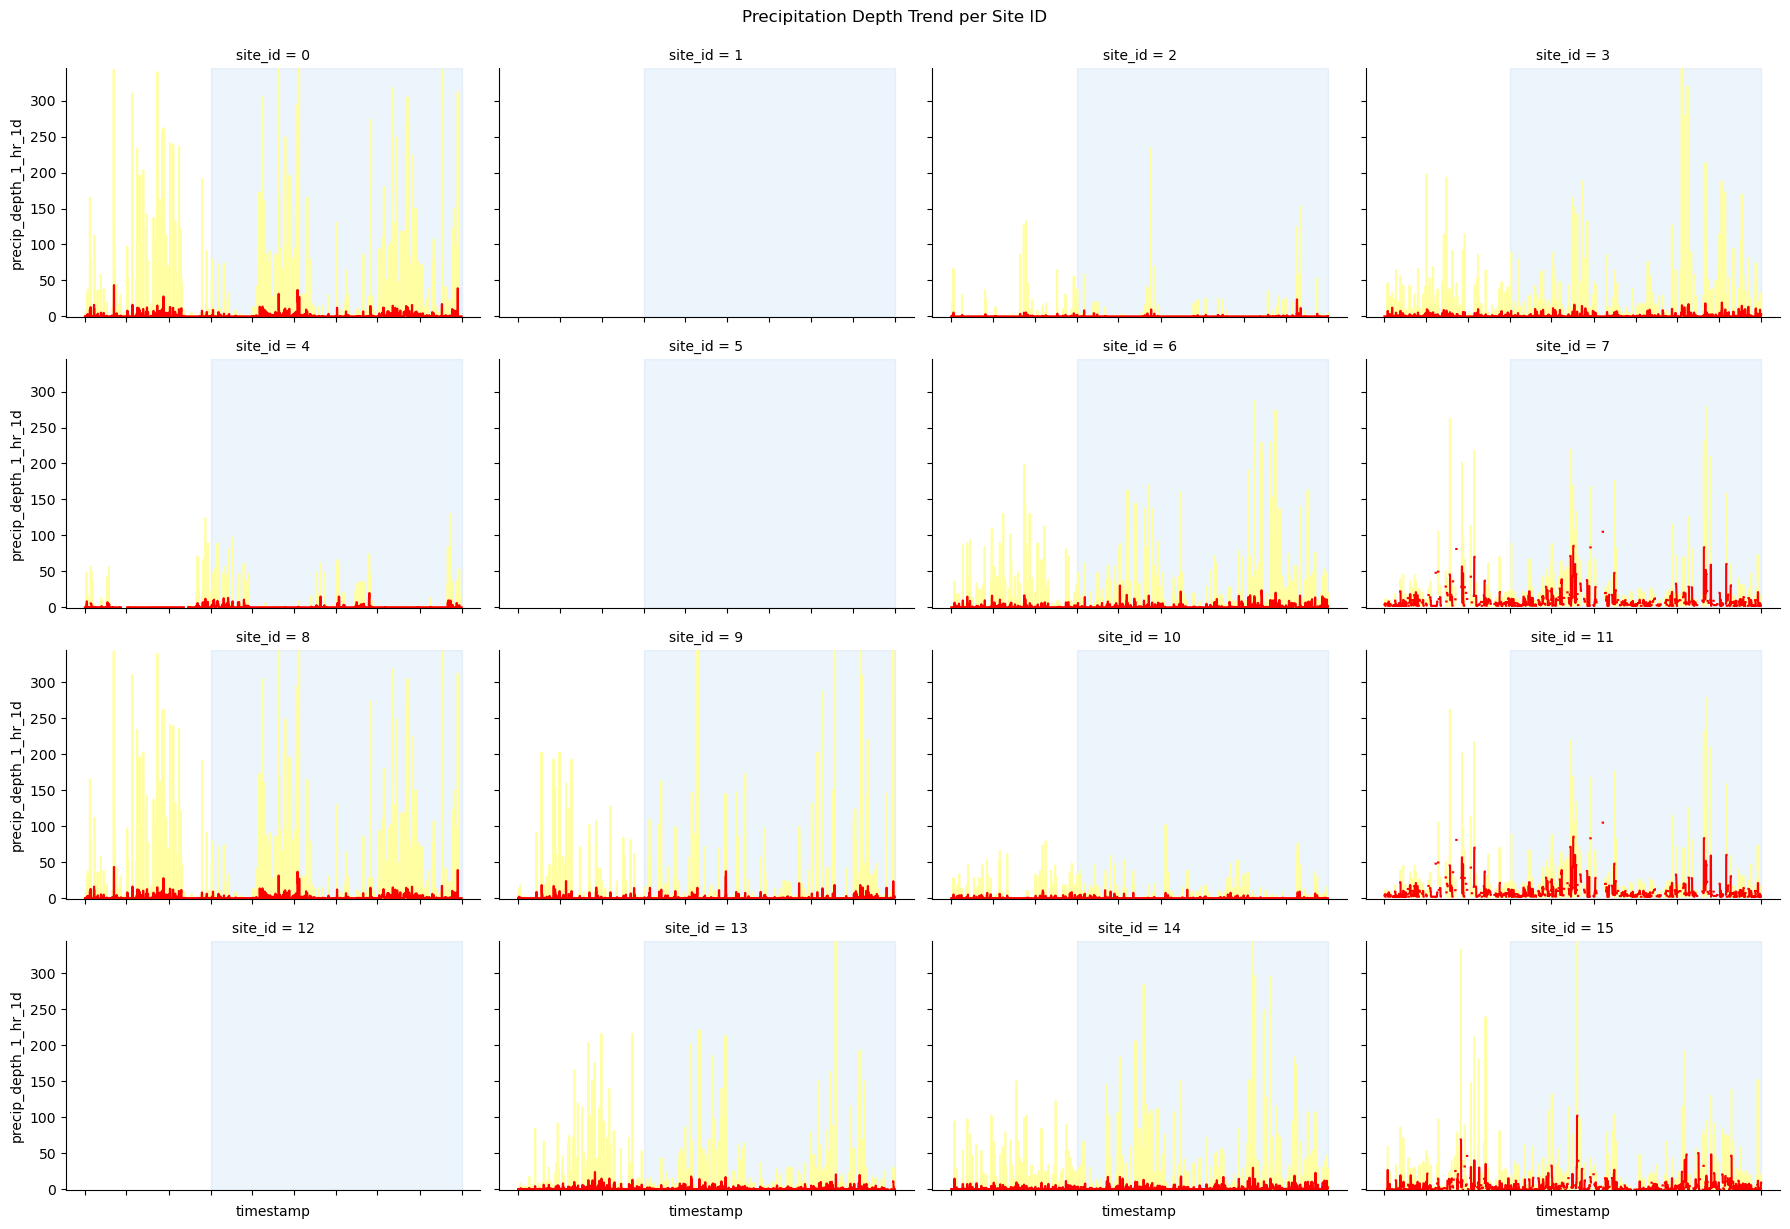

In [76]:
grid = sns.FacetGrid(weather_plus1, col="site_id", col_wrap=4, height=3, aspect=1.5, sharex=True, sharey=True)
grid.map(plt.axvspan, xmin=weather_test['timestamp'].min(), xmax=weather_test['timestamp'].max(), facecolor='green', alpha=0.2)
grid.map_dataframe(plt.plot, 'timestamp', 'precip_depth_1_hr', color=pal[-2], alpha=1)
grid.map_dataframe(plt.plot, 'timestamp', 'precip_depth_1_hr_1d', color='red', alpha=1)
grid.set(ylim=(-1,345))
grid.set_xticklabels(rotation=45)
grid.fig.tight_layout(w_pad=1)
plt.suptitle('Precipitation Depth Trend per Site ID', y=1.02)
plt.show()

Site 1, site 5 and site 12 don't have any measurement for precipitation depth. It is peculiar to have no rain at all. Maybe these sites don't have any measuring device installed for this measurement.<br>
Site 2, 4, and 10 are mostly dry.
Site 7, 11, and 15 have the most rain.

##### 3.3.3.5. Sea Level Pressure

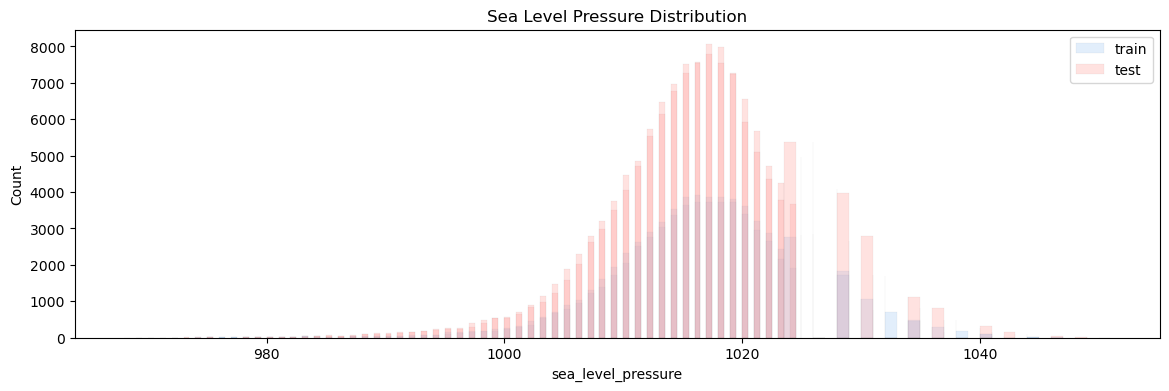

In [77]:
plt.figure(figsize=(14,4))
sns.histplot(data=weather_train, x='sea_level_pressure', color=pal[0], kde=True, alpha=0.3, linewidth=0.02, label='train')
sns.histplot(data=weather_test, x='sea_level_pressure', color=pal[3], kde=True, alpha=0.3, linewidth=0.02, label='test')
plt.title('Sea Level Pressure Distribution')
plt.legend()
plt.show()

Sea level pressure are quite similar in both datasets.

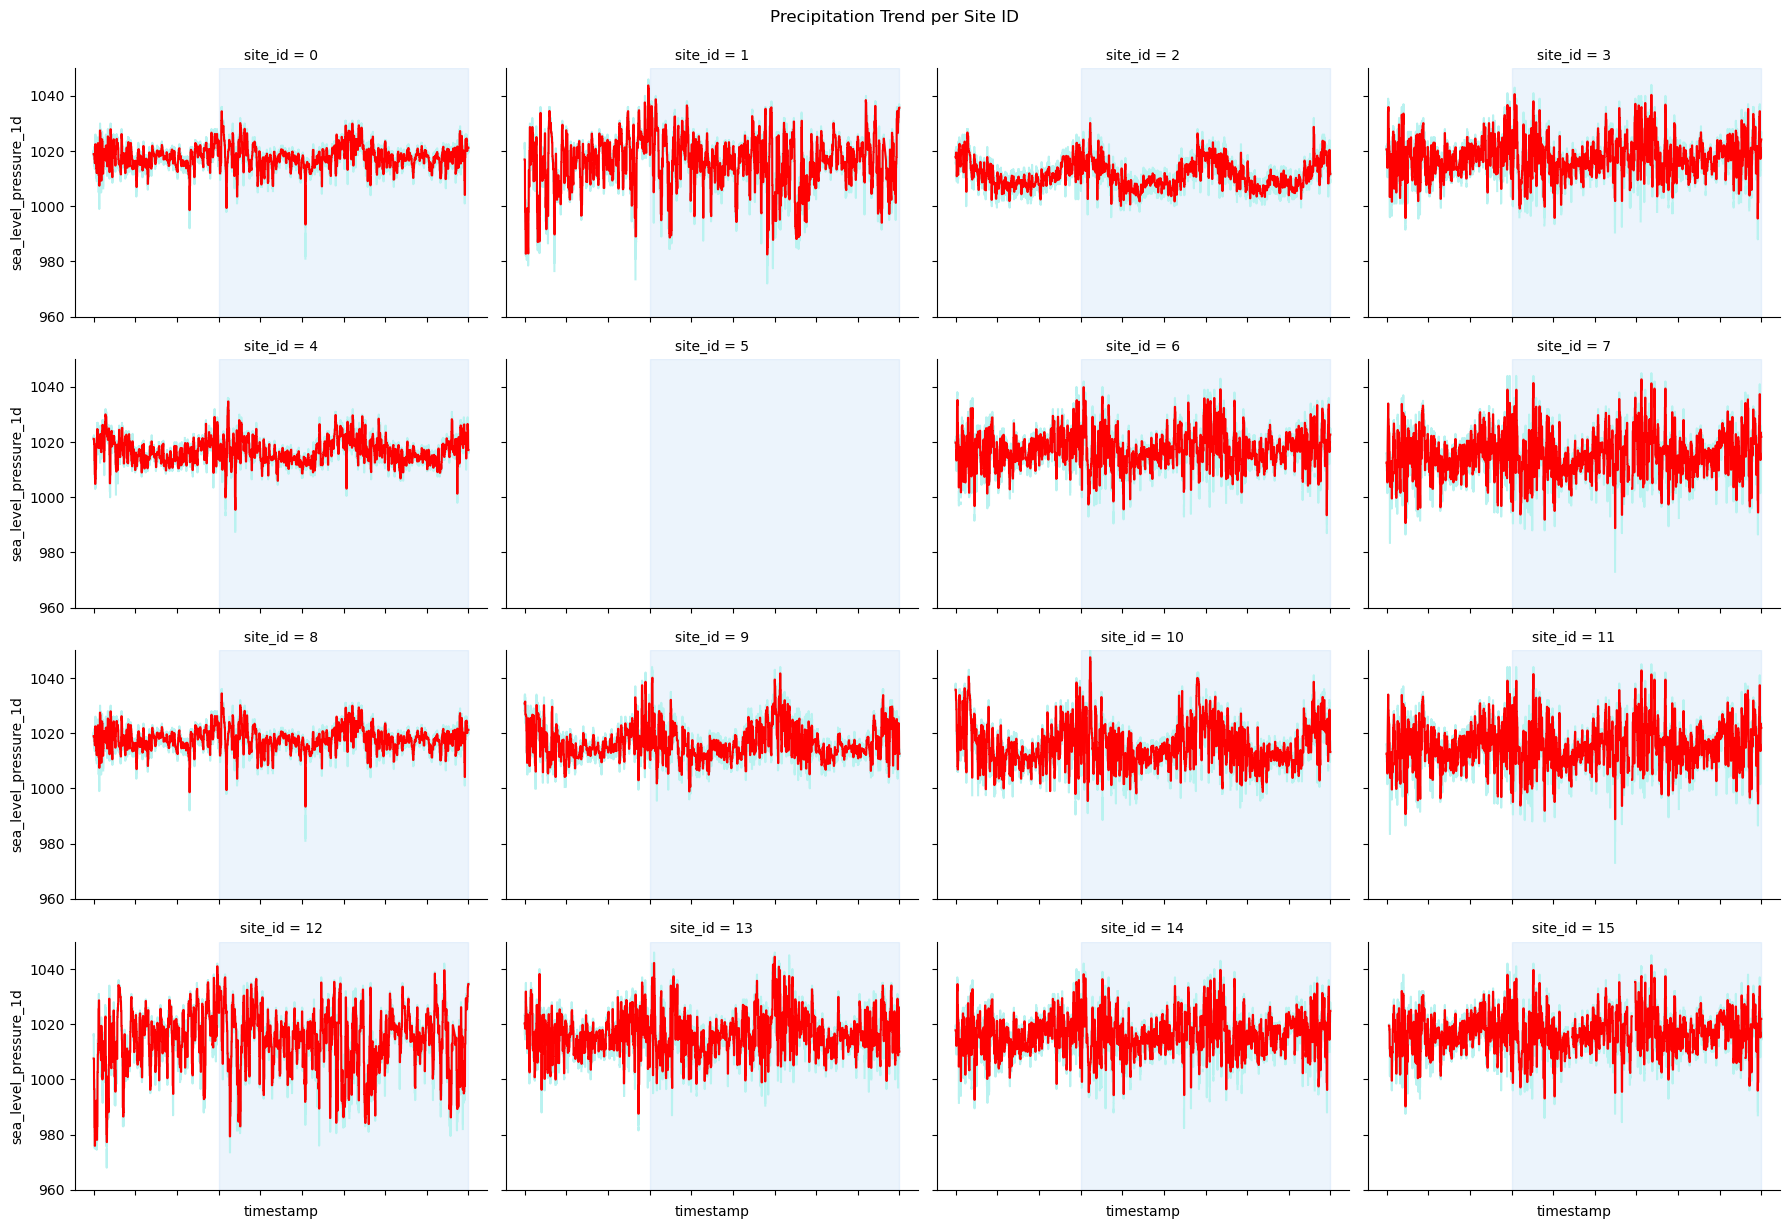

In [78]:
grid = sns.FacetGrid(weather_plus1, col="site_id", col_wrap=4, height=3, aspect=1.5, sharex=True, sharey=True)
grid.map(plt.axvspan, xmin=weather_test['timestamp'].min(), xmax=weather_test['timestamp'].max(), facecolor='green', alpha=0.2)
grid.map_dataframe(plt.plot, 'timestamp', 'sea_level_pressure', color=pal[-1], alpha=1)
grid.map_dataframe(plt.plot, 'timestamp', 'sea_level_pressure_1d', color='red', alpha=1)
grid.set(ylim=(960,1050))
grid.set_xticklabels(rotation=45)
grid.fig.tight_layout(w_pad=1)
plt.suptitle('Precipitation Trend per Site ID', y=1.02)
plt.show()

Site 5 doesn't have any sea level pressure measurement, maybe measuring device isn't installed here.<br>
Site 1, and 12 have the most fluctuation in sea level pressure, maybe these sites are nearer to the mountains or coastlines.

##### 3.3.3.6. Wind Direction and Wind Speed

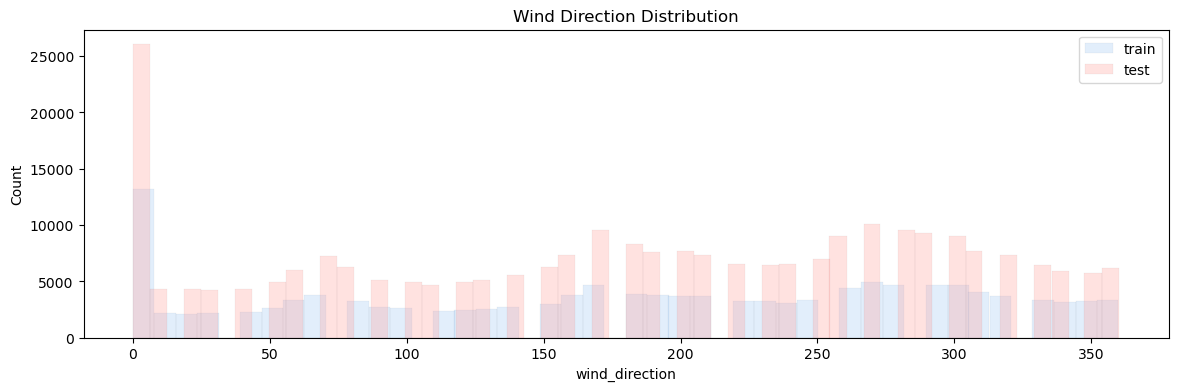

In [79]:
plt.figure(figsize=(14,4))
sns.histplot(data=weather_train, x='wind_direction', color=pal[0], kde=True, alpha=0.3, linewidth=0.02, label='train')
sns.histplot(data=weather_test, x='wind_direction', color=pal[3], kde=True, alpha=0.3, linewidth=0.02, label='test')
plt.title('Wind Direction Distribution')
plt.legend()
plt.show()

Wind direction distribution are quite similar in both datasets.

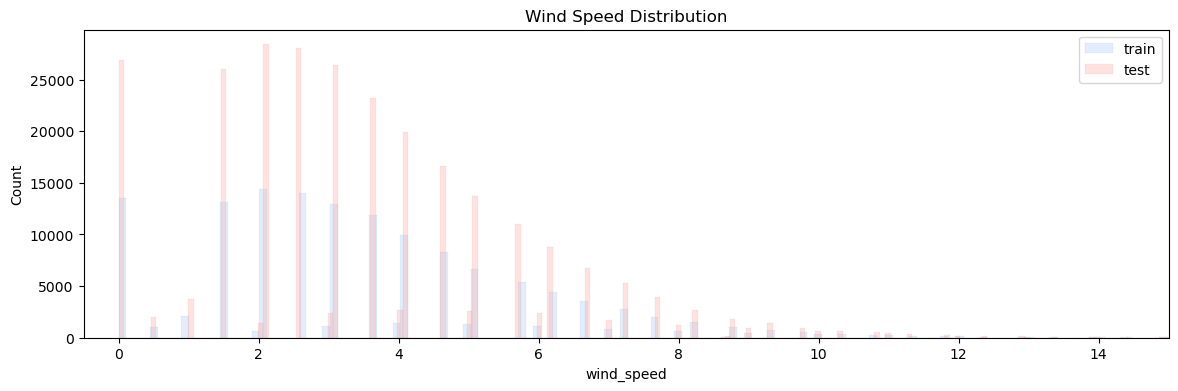

In [80]:
plt.figure(figsize=(14,4))
sns.histplot(data=weather_train, x='wind_speed', color=pal[0], kde=True, alpha=0.3, linewidth=0.02, label='train')
sns.histplot(data=weather_test, x='wind_speed', color=pal[3], kde=True, alpha=0.3, linewidth=0.02, label='test')
plt.title('Wind Speed Distribution')
plt.xlim([-0.5,15])
plt.legend()
plt.show()

Wind speed distribution are quite similar in both datasets with the most counts on 2-3 m/s.

In [81]:
weather_train_dir = weather_train.groupby('wind_direction').mean().reset_index()
weather_test_dir = weather_test.groupby('wind_direction').mean().reset_index()

Convert direction into radians.

In [82]:
# Convert direction from degrees to radians
weather_train_dir['wind_direction_rad'] = weather_train_dir['wind_direction'] * (np.pi / 180)
weather_test_dir['wind_direction_rad'] = weather_train_dir['wind_direction'] * (np.pi / 180)

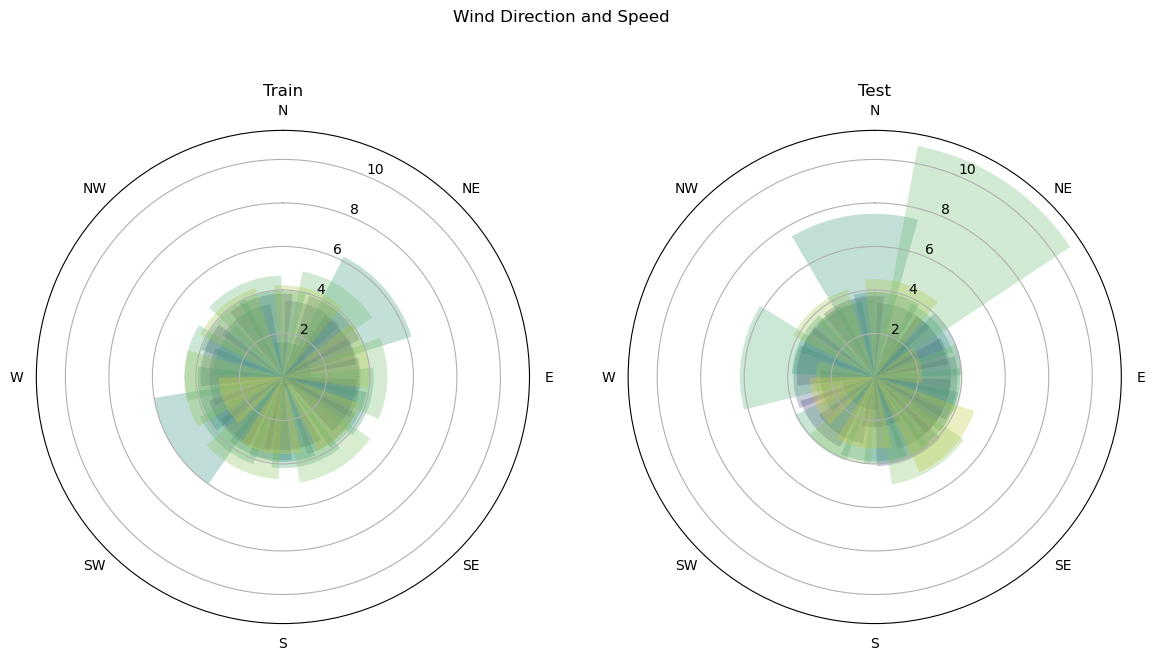

In [83]:
# Create a compass
fig, ax = plt.subplots(1, 2, figsize=(14,7), sharex=True, sharey=True, subplot_kw={'projection': 'polar'})
direction_labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
plt.suptitle('Wind Direction and Speed', y=1.02)

to_plot = [weather_train_dir, weather_test_dir]
for i, df in enumerate(to_plot):
    theta = df['wind_direction_rad']
    radius = df['wind_speed']
    sns.barplot(x=theta, y=radius, palette='viridis', alpha=0.3, ax=ax[i])
    ax[i].set(
        title='Train' if i==0 else 'Test',
        xticks = np.arange(0, 2*np.pi, 2*np.pi/len(direction_labels)),
        xticklabels = direction_labels,
        xlim=[0, 2*np.pi],
        xlabel='',
        ylabel='',
        theta_direction='clockwise',
        theta_zero_location='N')

plt.show()

Generally, train set and test set has similar wind properties, except for the outliers, in which train set outliers blow in Northeast and Southwest direction, and test set outliers blow in West to Norteast direction.

##### 3.3.3.7. Overall

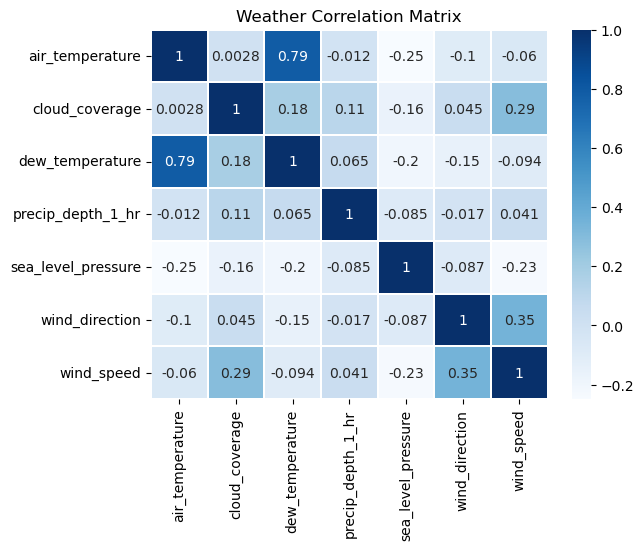

In [84]:
sns.heatmap(weather.drop('site_id', axis=1).corr(), annot=True, linewidths=0.1, cmap='Blues').set(title='Weather Correlation Matrix')
plt.show()

Air temperature and dew temperature are strongly correlated. One of this feature can be removed when training prediction model.<br>
Wind direction and wind speed; and wind direction and cloud coverage have weak correlations. They probably won't affect the prediction.

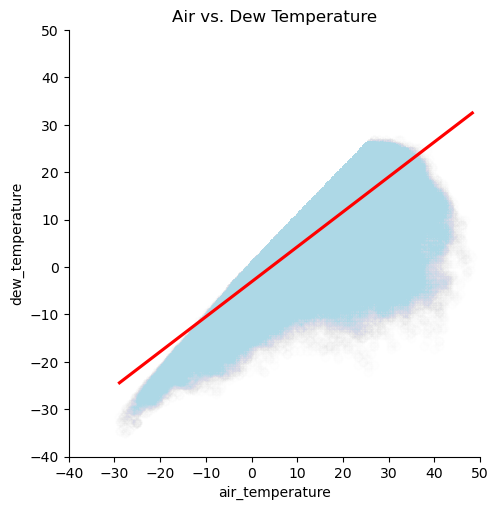

In [85]:
sns.lmplot(data=weather, x='air_temperature', y='dew_temperature', scatter_kws=dict(alpha=0.01, color='lightblue'), line_kws={'color': 'red'})\
.set(title='Air vs. Dew Temperature')
plt.xlim([-40,50])
plt.ylim([-40,50])
plt.show()

As we can see, dew temperature never exceed air temperature. The two are linearly correlated.

#### 3.3.3. Processing Data

Impute all missing data with mean per site id since there is no outliers in the columns with missing values.

In [86]:
col_to_map = ['air_temperature','cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']

for col in col_to_map:
    weather_train[col] = weather_train[col].fillna(weather_train['site_id'].map(dict(weather_train.groupby('site_id')[col].median())))
    weather_test[col] = weather_test[col].fillna(weather_test['site_id'].map(dict(weather_test.groupby('site_id')[col].median())))

Show current missing values.

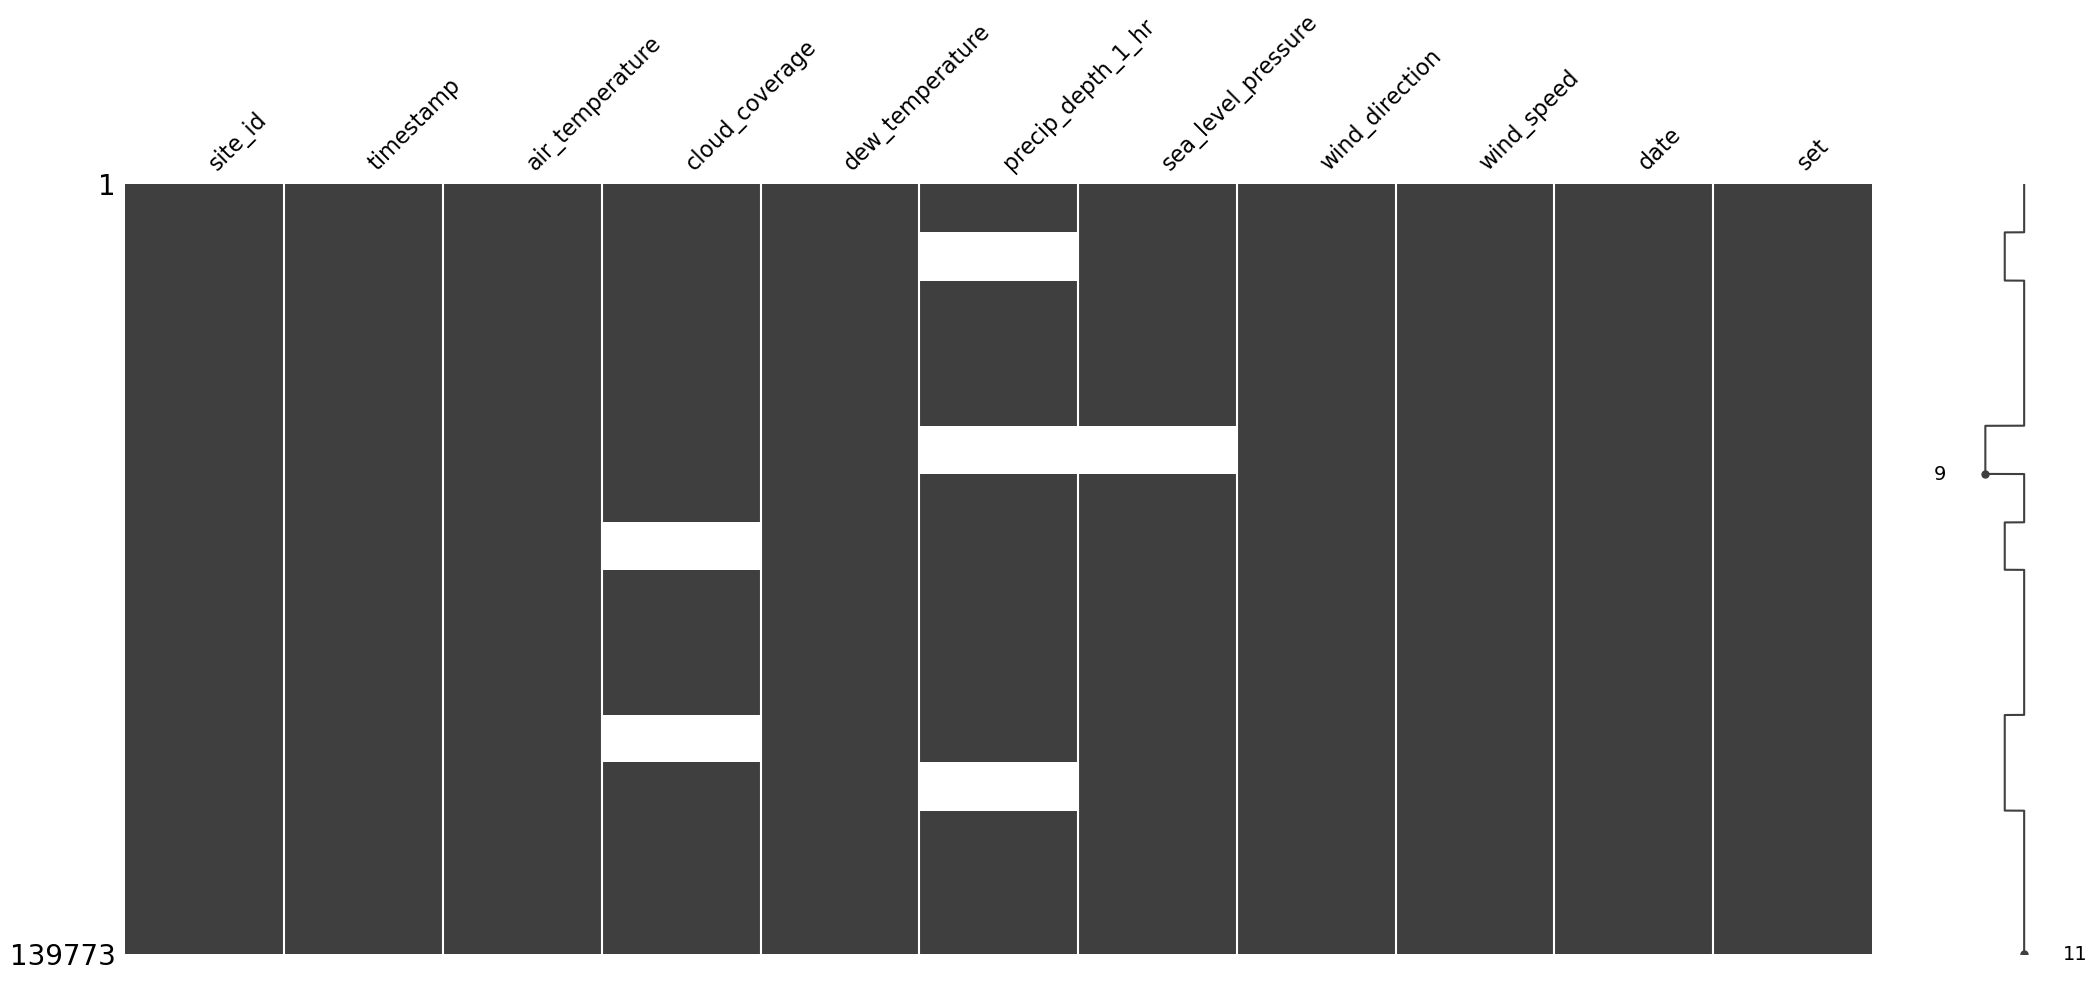

In [87]:
msno.matrix(weather_train.sort_values(by=['site_id','timestamp']))
plt.show()

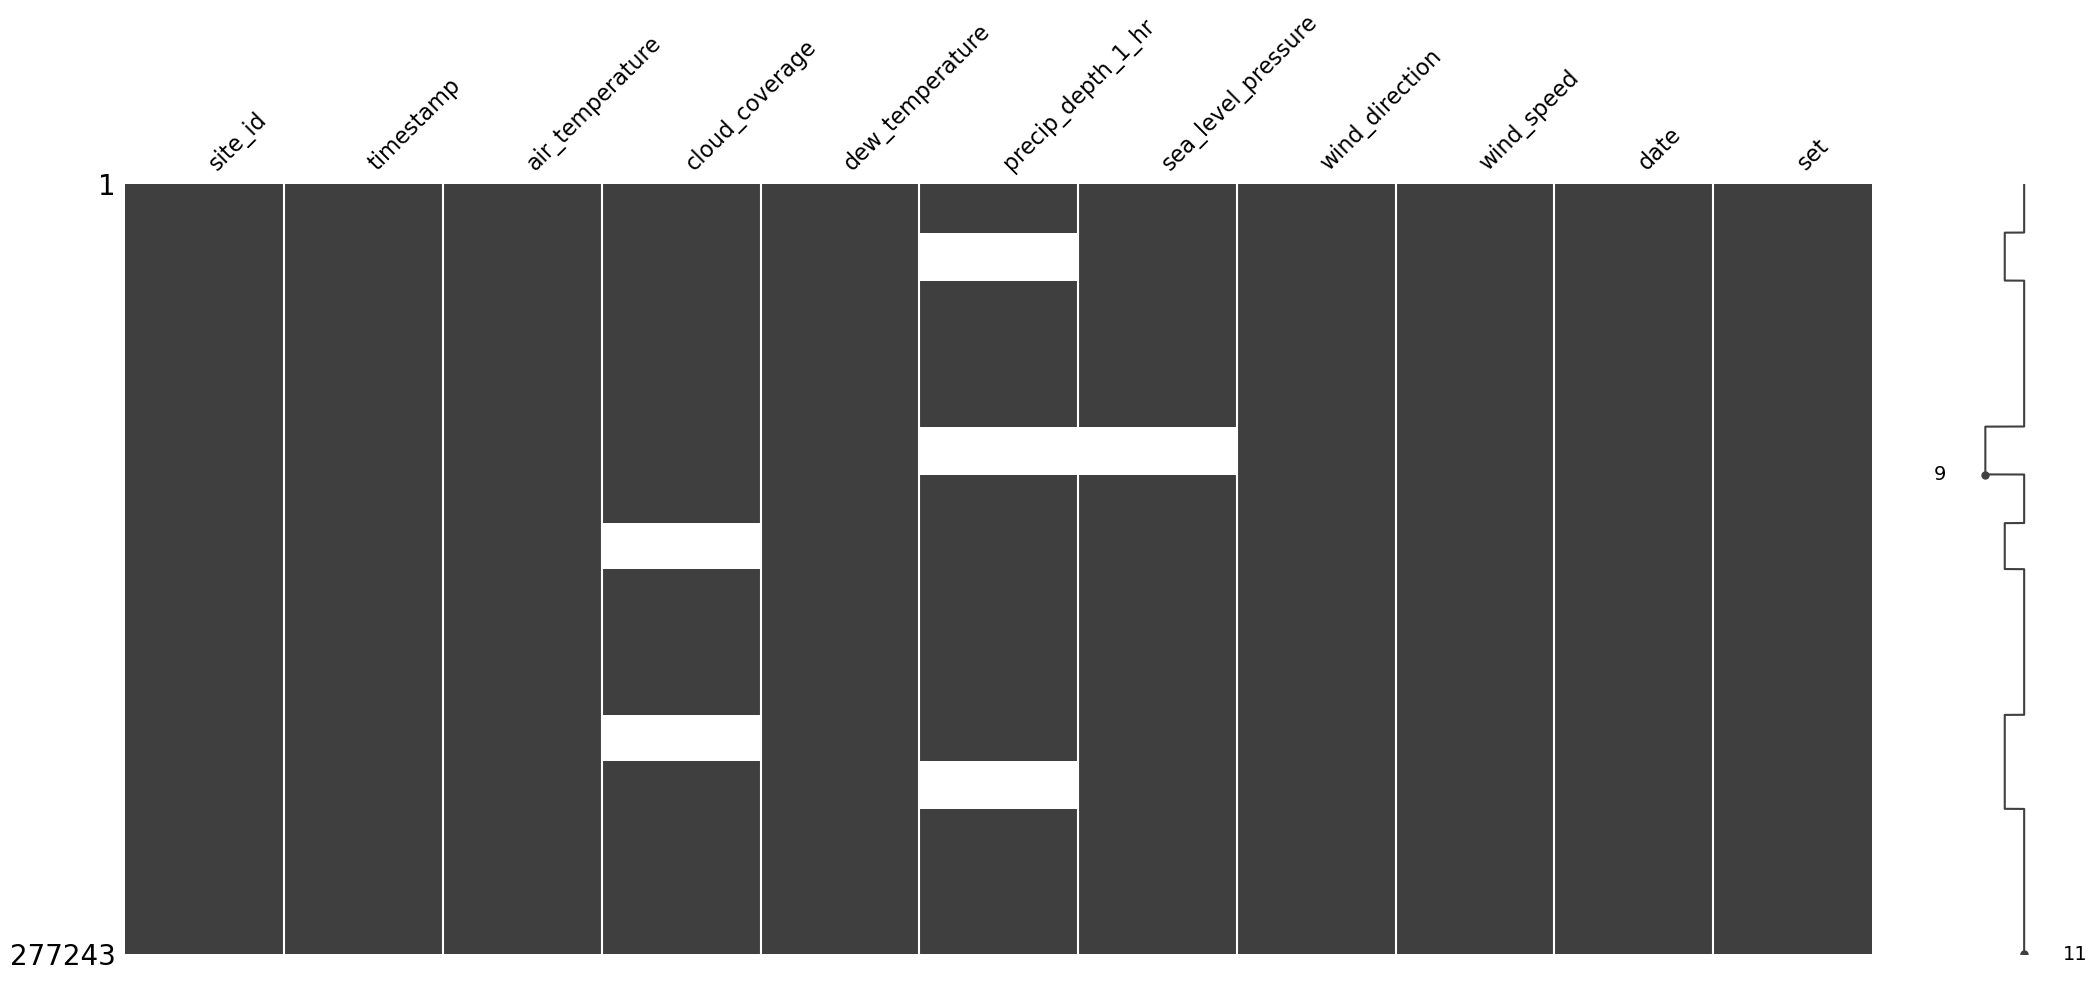

In [88]:
msno.matrix(weather_test.sort_values(by=['site_id','timestamp']))
plt.show()

Impute remaining missing value with overall median per column.

In [89]:
col_to_map2 = ['cloud_coverage', 'precip_depth_1_hr', 'sea_level_pressure']

for col in col_to_map2:
    weather_train[col] = weather_train[col].fillna(weather_train[col].median())
    weather_test[col] = weather_test[col].fillna(weather_test[col].median())

Plot distributions of imputed data.

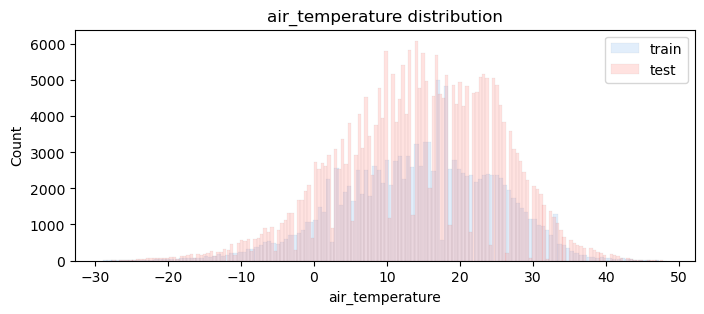

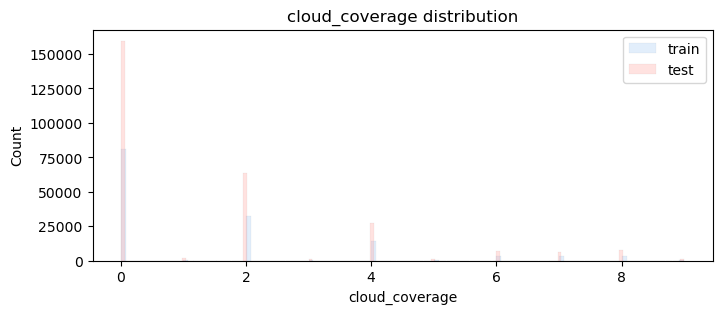

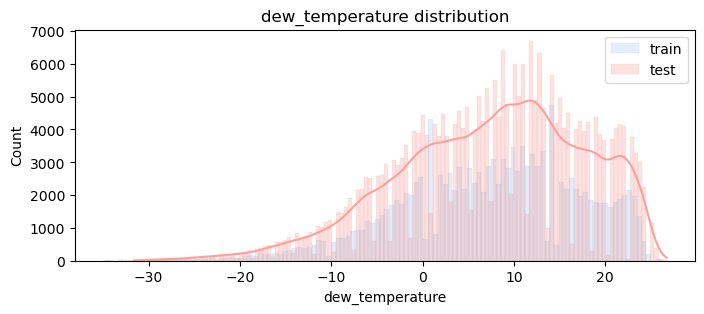

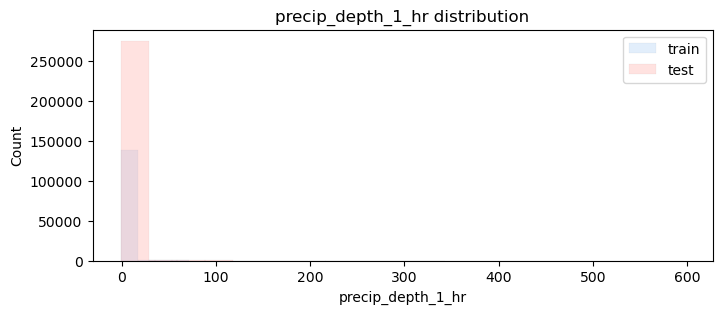

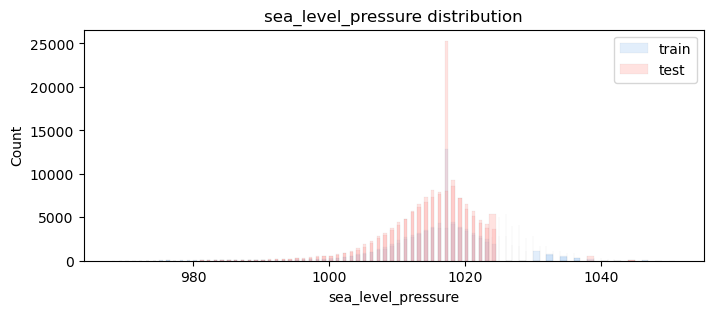

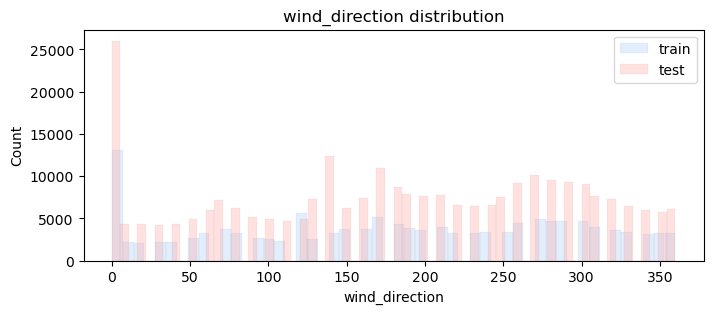

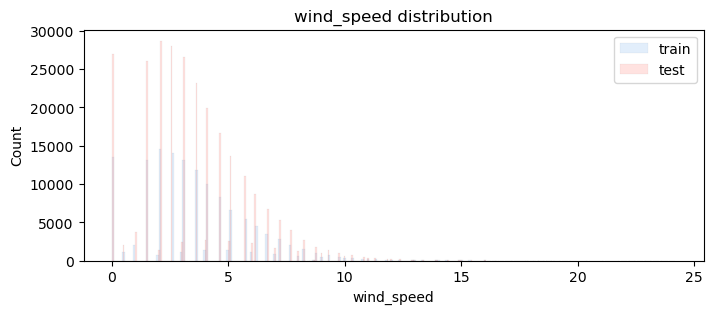

In [90]:
for col in col_to_map:
    plt.figure(figsize=(8,3))
    sns.histplot(data=weather_train, x=col, color=pal[0], kde=True, alpha=0.3, linewidth=0.02, label='train')
    sns.histplot(data=weather_test, x=col, color=pal[3], kde=True, alpha=0.3, linewidth=0.02, label='test')
    plt.title(col + ' distribution')
    plt.legend()
    plt.show()

No significant changes made.

[back to table of contents](#back)

### 3.4. Building <a id='build'></a>

#### 3.4.1. Understanding Data

In [91]:
building.head()

site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432      2008.0          NaN
1        0            1   Education         2720      2004.0          NaN
2        0            2   Education         5376      1991.0          NaN
3        0            3   Education        23685      2002.0          NaN
4        0            4   Education       116607      1975.0          NaN

In [92]:
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int8   
 1   building_id  1449 non-null   int16  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int32  
 4   year_built   675 non-null    float16
 5   floor_count  355 non-null    float16
dtypes: float16(2), int16(1), int32(1), int8(1), object(1)
memory usage: 27.0+ KB


All of the data is in the right datatype.

In [93]:
building.describe().T

count          mean            std     min      25%      50%  \
site_id      1449.0  6.952381e+00       5.003432     0.0      3.0      5.0   
building_id  1449.0  7.240000e+02     418.434583     0.0    362.0    724.0   
square_feet  1449.0  9.211178e+04  110769.950997   283.0  23012.0  57673.0   
year_built    675.0           inf      31.062500  1900.0   1949.0   1970.0   
floor_count   355.0  3.740234e+00       3.333984     1.0      1.0      3.0   

                  75%       max  
site_id          13.0      15.0  
building_id    1086.0    1448.0  
square_feet  115676.0  875000.0  
year_built     1995.0    2017.0  
floor_count       5.0      26.0

In [94]:
building.duplicated().sum()

0

No duplicated rows.

In [95]:
building.isna().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

There are some missing values in year built and floor count.

In [96]:
building['primary_use'].unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

There are no redundant values in primary use column.

#### 3.4.2. Plots

##### 3.4.2.1. Primary Use

In [97]:
building['primary_use'].value_counts().values

array([549, 279, 184, 156, 147,  25,  23,  22,  13,  12,  11,  10,   6,
         5,   4,   3], dtype=int64)

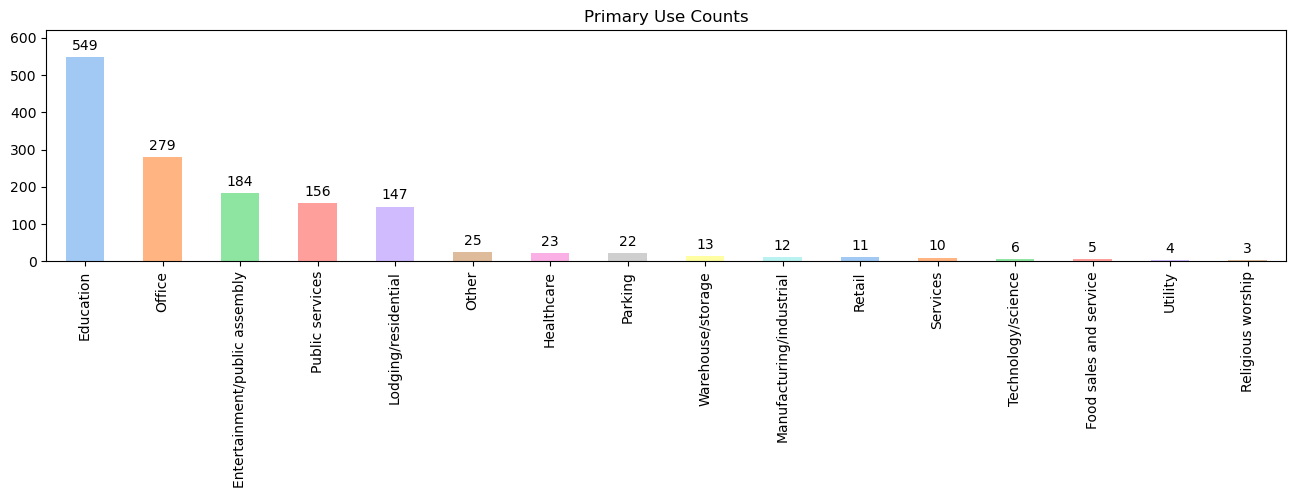

In [98]:
plt.figure(figsize=(16, 3))
bars = building['primary_use'].value_counts().plot(kind='bar', color=sns.color_palette())
for bar in bars.patches:
    plt.annotate(f'{bar.get_height()}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom')
plt.title('Primary Use Counts')
plt.ylim([0,620])
plt.show()

This dataset is mostly consisted of building for education purpose followed by office building.

##### 3.4.2.2. Floor Counts

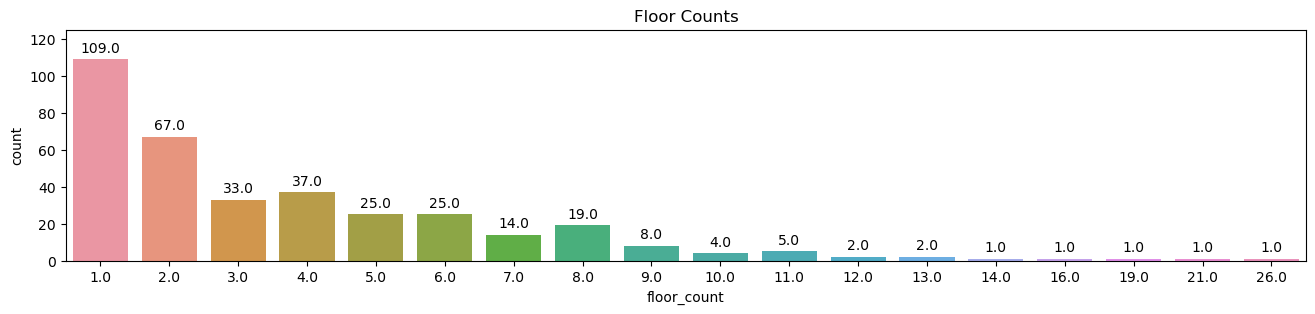

In [99]:
plt.figure(figsize=(16, 3))
bars = sns.countplot(data=building, x='floor_count')
bars.set_title('Floor Counts')
for bar in bars.patches:
    plt.annotate(f'{bar.get_height()}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom')
plt.ylim([0,125])
plt.show()

Most of the buildings have 1 floor.

##### 3.4.2.3. Square Feet

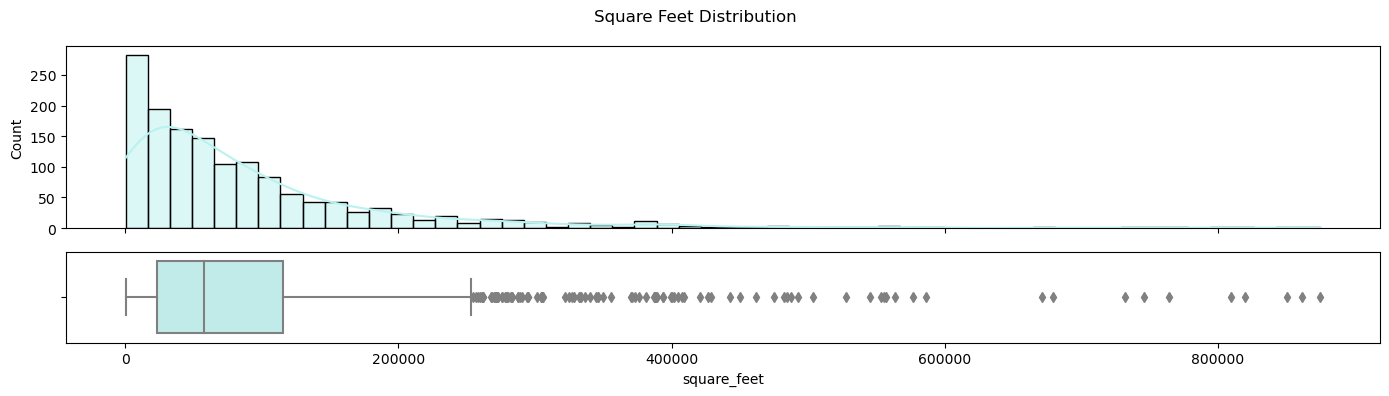

In [100]:
fig, ax = plt.subplots(2, 1, figsize=(14,4), sharex=True, gridspec_kw = {'height_ratios':[2, 1]})
sns.histplot(data=building, x='square_feet', color=pal[-1], kde=True, ax=ax[0])
sns.boxplot(data=building, x='square_feet', color=pal[-1], ax=ax[1])
plt.suptitle('Square Feet Distribution')
plt.tight_layout()
plt.show()

Most of the buildings have little areas.

##### 3.4.2.4. Year Built

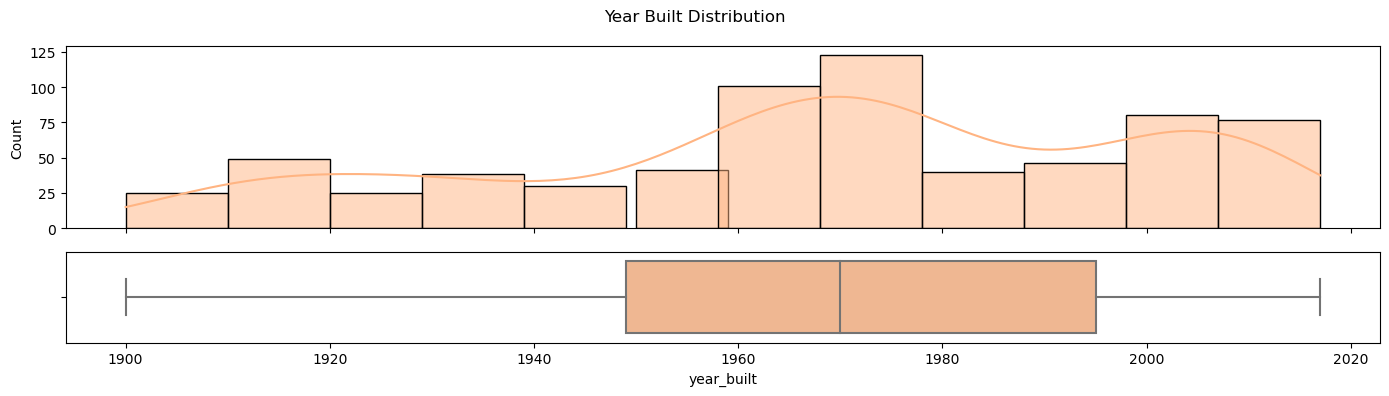

In [101]:
fig, ax = plt.subplots(2, 1, figsize=(14,4), sharex=True, gridspec_kw = {'height_ratios':[2, 1]})
sns.histplot(data=building, x='year_built', color=pal[1], kde=True, ax=ax[0])
sns.boxplot(data=building, x='year_built', color=pal[1], ax=ax[1])
plt.suptitle('Year Built Distribution')
plt.tight_layout()
plt.show()

Most of the buildings are built on 1970s.

##### 3.4.2.5. Overall

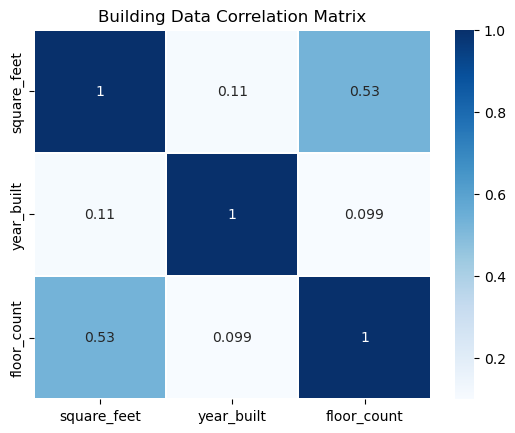

In [102]:
sns.heatmap(building.drop(['site_id','building_id','primary_use'], axis=1).corr(), annot=True, linewidths=0.1, cmap='Blues').set(title='Building Data Correlation Matrix')
plt.show()

Square feet and floor count are moderately correlated.

#### 3.3.3. Processing Data

Fill missing year built with mean.

In [103]:
building['year_built'] = building['year_built'].fillna(building['year_built'].median())
building['year_built'] = building['year_built'].fillna(building['year_built'].median())

For the missing floor count values, they will be ignored since the model training won't involve the column.

Show current missing values.

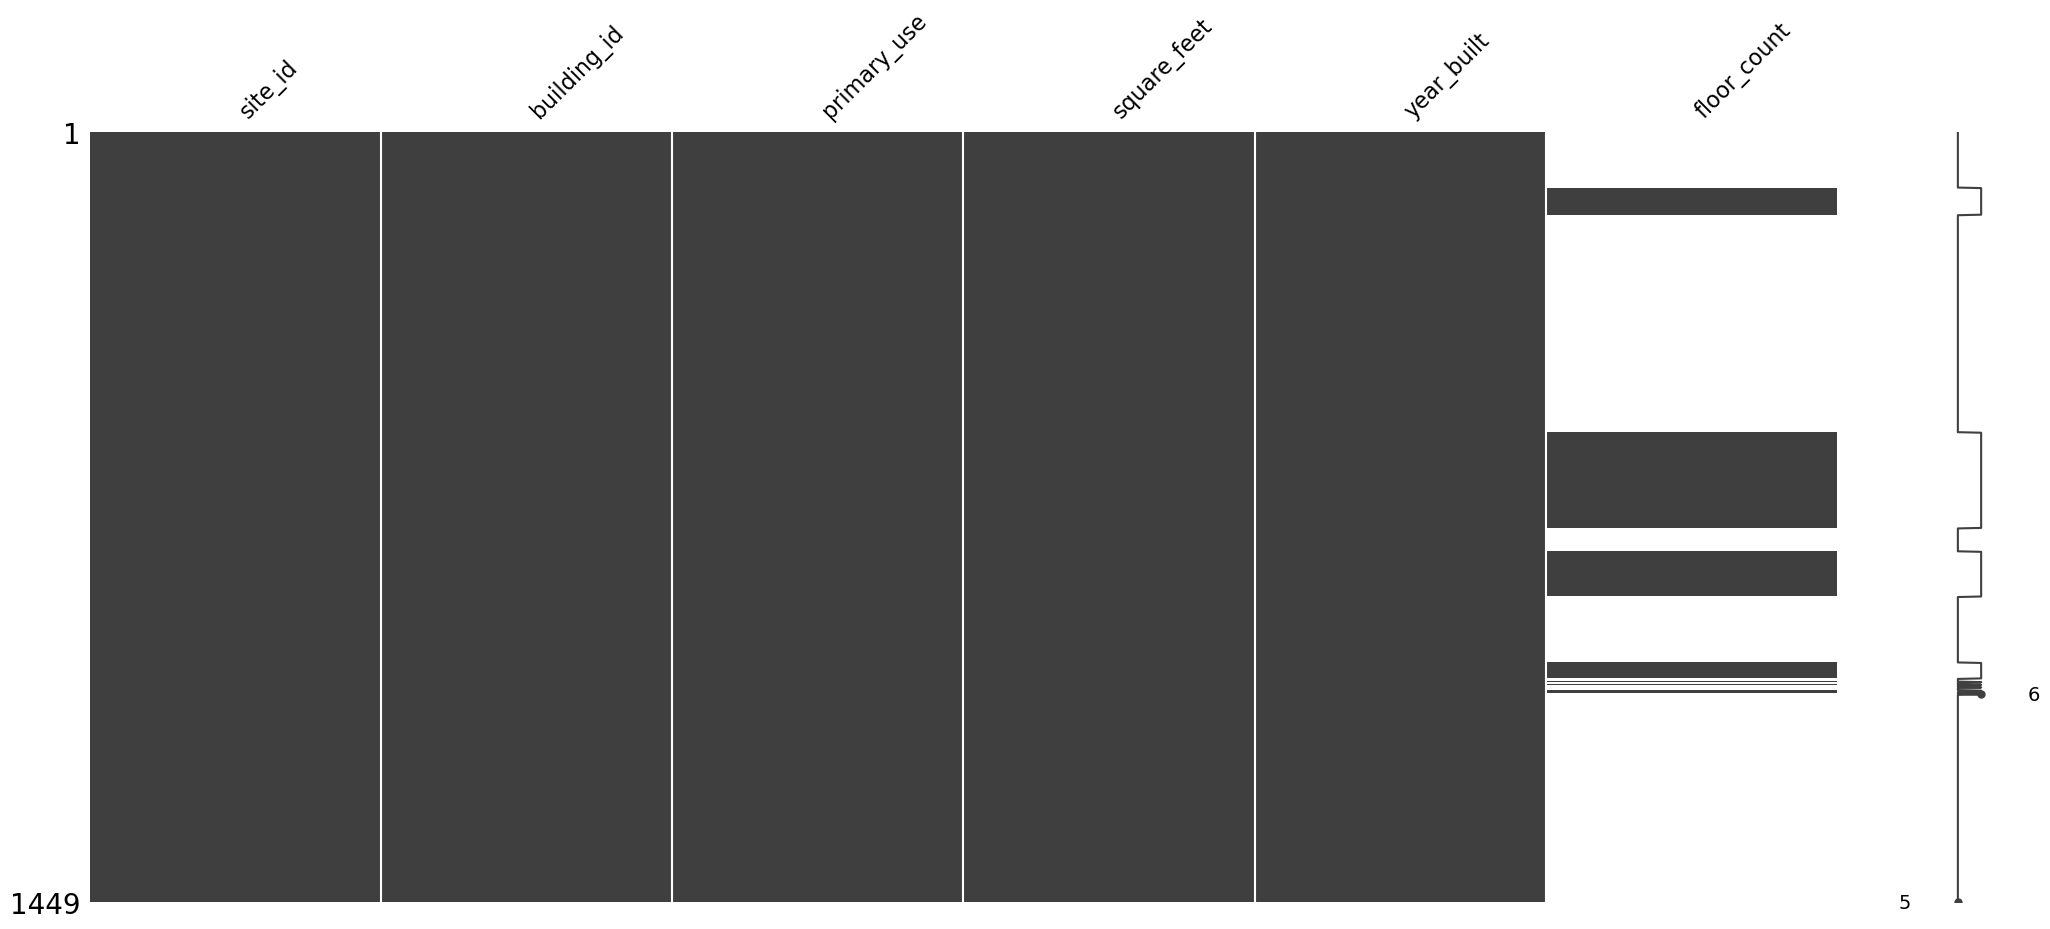

In [104]:
msno.matrix(building)
plt.show()

[back to table of contents](#back)

### 3.5. Merged Dataset <a id='merge'></a>

#### 3.5.1. Merge Dataset

In [105]:
train = train.merge(building, on='building_id', how='left').merge(weather_train, on=['site_id','timestamp'], how='left')
test = test.merge(building, on='building_id', how='left').merge(weather_test, on=['site_id','timestamp'], how='left')

In [106]:
%whos

Variable                  Type               Data/Info
------------------------------------------------------
ax                        ndarray            2: 2 elems, type `object`, 16 bytes
bar                       Rectangle          Rectangle(xy=(16.6, 0), w<...>h=0.8, height=1, angle=0)
bars                      Axes               Axes(0.125,0.11;0.775x0.77)
building                  DataFrame                site_id  building_i<...>\n[1449 rows x 6 columns]
col                       str                wind_speed
col_to_map                list               n=7
col_to_map2               list               n=3
date                      type               <class 'datetime.date'>
decomposed                DecomposeResult    <statsmodels.tsa.seasonal<...>ct at 0x000001812348EE60>
df                        DataFrame              wind_direction   site<...>n59                 NaN  
df_to_compress            dict               n=5
direction_labels          list               n=8
fig        

Remove unused objects to improve model training speed.

In [107]:
#delete all unused objects
del ax, bar, bars, col_to_map, col_to_map2, decomposed, df, df_to_compress, direction_labels, fig, filter, grid, i, id, is_categorical_dtype, is_datetime64_any_dtype, name, pal, path, radius, reduce_mem_usage, reduce_mem_usage_samp, site_0_building_id, theta, to_plot, train_by_id, weather_1d, weather_plus1, weather_test_dir, weather_train_dir

In [108]:
%whos

Variable             Type         Data/Info
-------------------------------------------
building             DataFrame          site_id  building_i<...>\n[1449 rows x 6 columns]
col                  str          wind_speed
date                 type         <class 'datetime.date'>
make_date_features   function     <function make_date_featu<...>es at 0x0000018100775630>
msno                 module       <module 'missingno' from <...>\missingno\\__init__.py'>
np                   module       <module 'numpy' from 'D:\<...>ges\\numpy\\__init__.py'>
pd                   module       <module 'pandas' from 'D:<...>es\\pandas\\__init__.py'>
plt                  module       <module 'matplotlib.pyplo<...>\\matplotlib\\pyplot.py'>
seasonal_decompose   function     <function seasonal_decomp<...>se at 0x0000018123ABF520>
sns                  module       <module 'seaborn' from 'D<...>s\\seaborn\\__init__.py'>
test                 DataFrame               row_id  buildi<...>696720 rows x 22 columns]

In [109]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68847 entries, 0 to 68846
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   building_id         68847 non-null  int64         
 1   meter               68847 non-null  int64         
 2   timestamp           68847 non-null  datetime64[ns]
 3   meter_reading       68847 non-null  float32       
 4   year                68847 non-null  int64         
 5   month               68847 non-null  int64         
 6   day                 68847 non-null  int64         
 7   dayofweek           68847 non-null  int64         
 8   rolling_mean        64477 non-null  float64       
 9   rolling_std         64477 non-null  float64       
 10  site_id             68847 non-null  int8          
 11  primary_use         68847 non-null  object        
 12  square_feet         68847 non-null  int32         
 13  year_built          68847 non-null  float16   

In [110]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3696720 entries, 0 to 3696719
Data columns (total 22 columns):
 #   Column              Dtype         
---  ------              -----         
 0   row_id              int32         
 1   building_id         int16         
 2   meter               int8          
 3   timestamp           datetime64[ns]
 4   year                int64         
 5   month               int64         
 6   day                 int64         
 7   dayofweek           int64         
 8   site_id             int8          
 9   primary_use         object        
 10  square_feet         int32         
 11  year_built          float16       
 12  floor_count         float16       
 13  air_temperature     float16       
 14  cloud_coverage      float16       
 15  dew_temperature     float64       
 16  precip_depth_1_hr   float16       
 17  sea_level_pressure  float16       
 18  wind_direction      float16       
 19  wind_speed          float16       
 20  da

In [111]:
train.isna().sum()

building_id               0
meter                     0
timestamp                 0
meter_reading             0
year                      0
month                     0
day                       0
dayofweek                 0
rolling_mean           4370
rolling_std            4370
site_id                   0
primary_use               0
square_feet               0
year_built                0
floor_count           57566
air_temperature         289
cloud_coverage          289
dew_temperature         289
precip_depth_1_hr       289
sea_level_pressure      289
wind_direction          289
wind_speed              289
date                    289
set                     289
dtype: int64

In [112]:
col_to_map = ['air_temperature','cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']

for col in col_to_map:
    train[col] = train[col].fillna(train['site_id'].map(dict(train.groupby('site_id')[col].median())))
    test[col] = test[col].fillna(test['site_id'].map(dict(test.groupby('site_id')[col].median())))

In [113]:
test.isna().sum()

row_id                      0
building_id                 0
meter                       0
timestamp                   0
year                        0
month                       0
day                         0
dayofweek                   0
site_id                     0
primary_use                 0
square_feet                 0
year_built                  0
floor_count           3101040
air_temperature             0
cloud_coverage              0
dew_temperature             0
precip_depth_1_hr           0
sea_level_pressure          0
wind_direction              0
wind_speed                  0
date                    15738
set                     15738
dtype: int64

In [114]:
col_to_map = ['air_temperature','cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']

for col in col_to_map:
    train[col] = train[col].fillna(train['site_id'].map(dict(train.groupby('site_id')[col].median())))
    test[col] = test[col].fillna(test['site_id'].map(dict(test.groupby('site_id')[col].median())))

#### 3.5.2. Explore Dataset

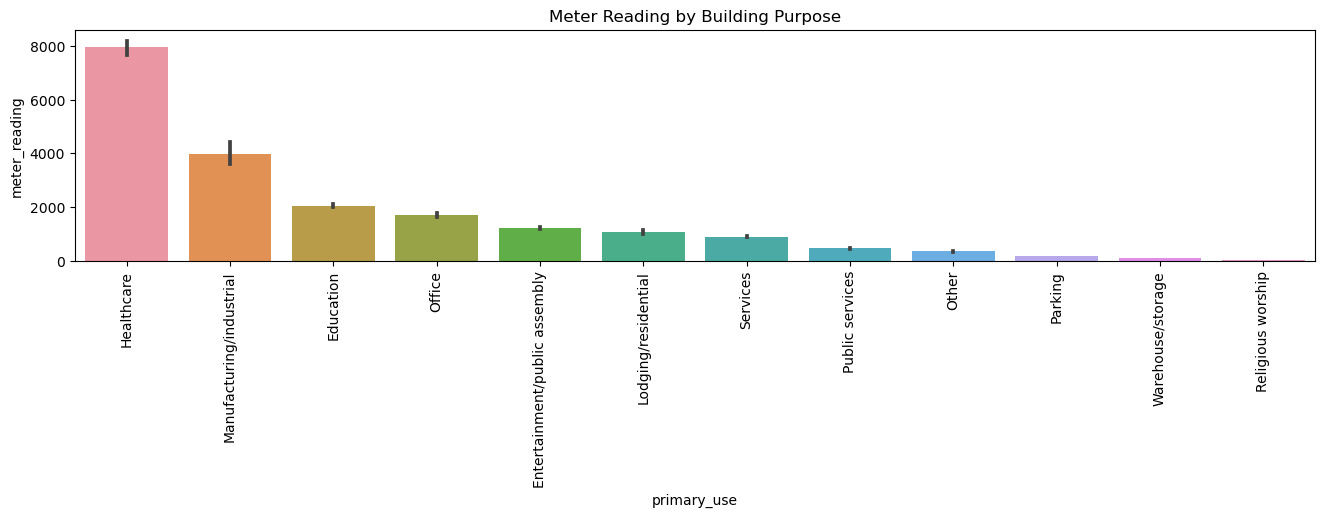

In [115]:
plt.figure(figsize=(16, 3))
sns.barplot(data=train, x='primary_use', y='meter_reading', order=train.groupby('primary_use')['meter_reading'].mean().sort_values(ascending=False).index)
plt.title('Meter Reading by Building Purpose')
plt.xticks(rotation=90)
plt.show()

On average, healthcare buildings have the most energy usage out of all. The least is religious worship buildings.

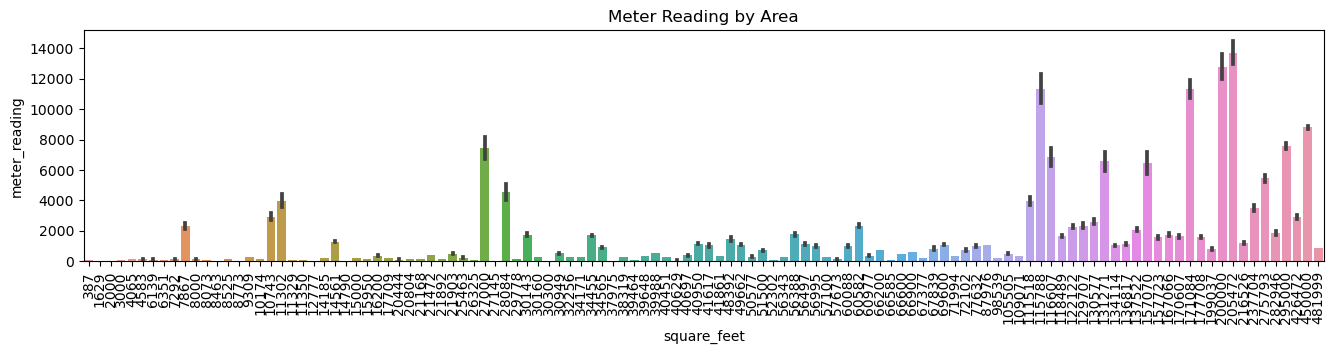

In [116]:
plt.figure(figsize=(16, 3))
sns.barplot(data=train, x='square_feet', y='meter_reading')
plt.title('Meter Reading by Area')
plt.xticks(rotation=90)
plt.show()

The wider the area of a building is, the higher its energy usage.

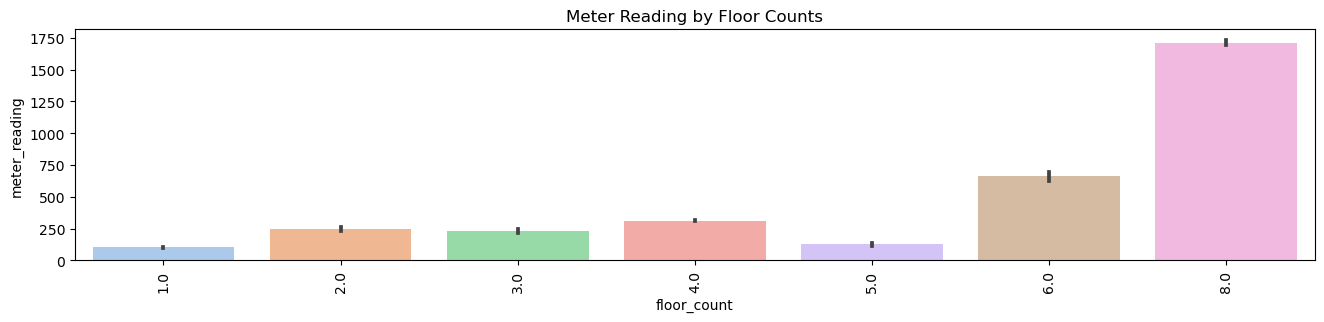

In [117]:
plt.figure(figsize=(16, 3))
sns.barplot(data=train, x='floor_count', y='meter_reading')
plt.title('Meter Reading by Floor Counts')
plt.xticks(rotation=90)
plt.show()

The higher a building is, the higher its energy usage.

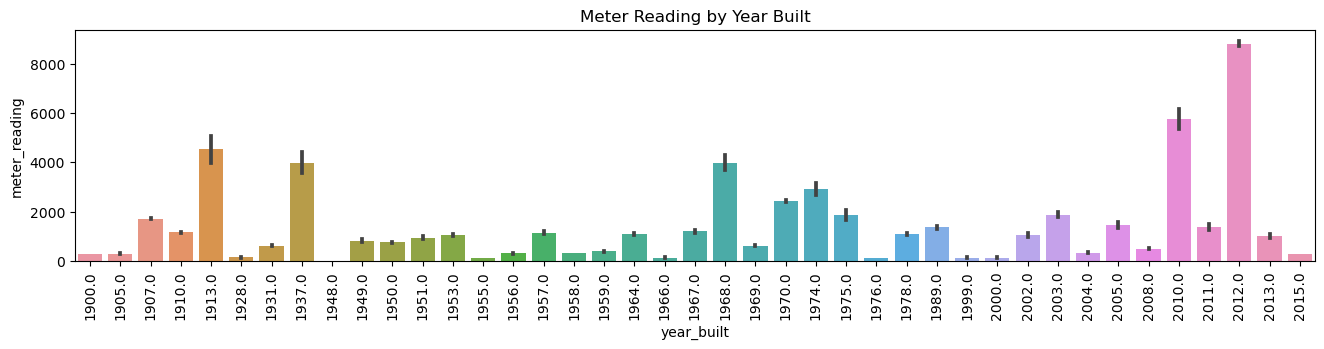

In [118]:
plt.figure(figsize=(16, 3))
sns.barplot(data=train, x='year_built', y='meter_reading')
plt.title('Meter Reading by Year Built')
plt.xticks(rotation=90)
plt.show()

On average, buildings built in 2012 has the most energy usage.

The higher a building is, the higher its energy usage.

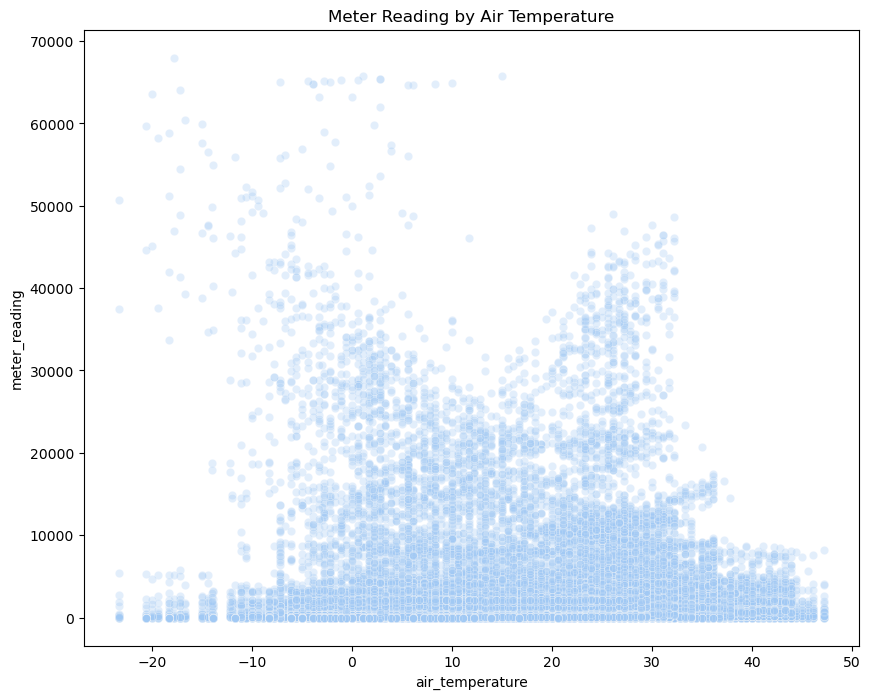

In [119]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=train, x='air_temperature', y='meter_reading', alpha=0.3)
plt.title('Meter Reading by Air Temperature')
plt.show()

The colder or hotter the temperature is, the higher the energy usage.

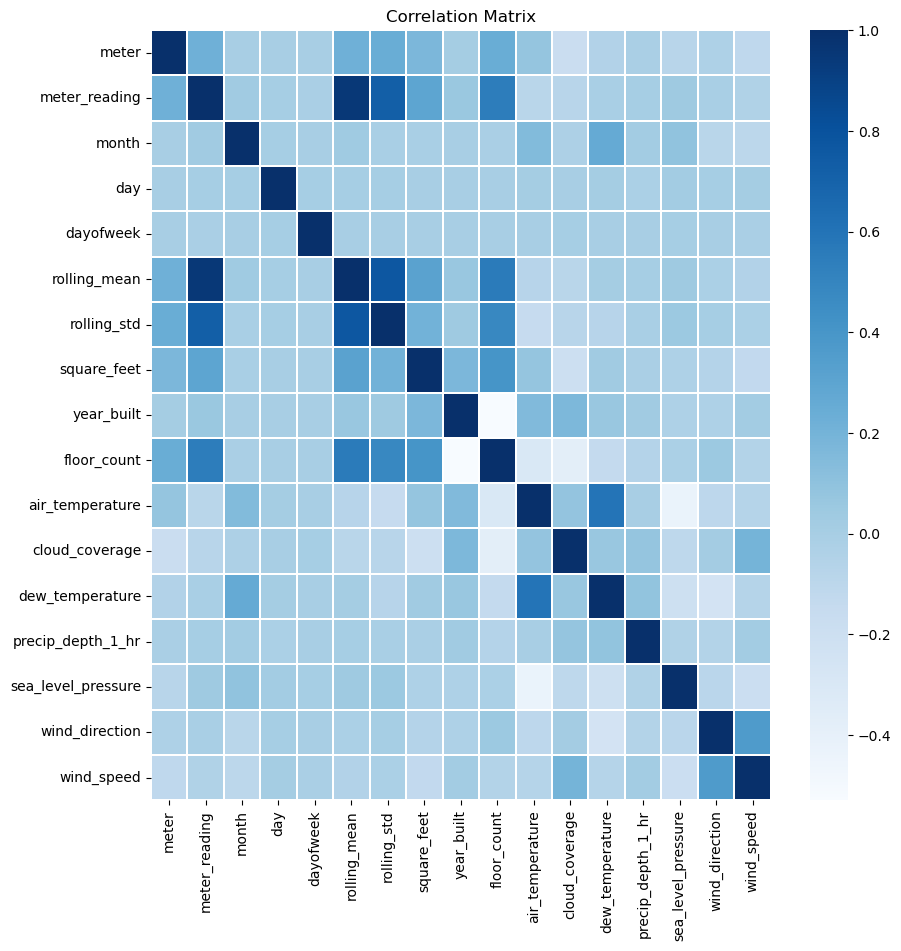

In [120]:
plt.figure(figsize=(10,10))
sns.heatmap(train.drop(['year', 'site_id', 'building_id', 'set'], axis=1).corr(), annot=False, linewidths=0.1, cmap='Blues').set(title='Correlation Matrix')
plt.show()

Meter reading is strongly correllated with rolling mean, rolling std, and floor count. It is also moderately correlated with square feet.<br>
Air temperature and dew temperature is strongly correlated.<br>
Square feet and floor count is moderately correlated.<br>
Floor count and year built is not correlated at all.

[back to table of contents](#back)

## 4. Model Development <a id='dev'></a>

### 4.1. Feature Selection <a id='dev1'></a>

Features that are highly correlated to each other will be removed:
* Timestamp
* Site id
* Floor count
* Dew temperature

Resulting features set will consists of:
* meter
* year
* month
* day
* dayofweek
* primary_use
* square_feet
* year_built
* air_temperature
* cloud_coverage
* precip_depth_1_hr
* sea_level_pressure
* wind_direction
* wind_speed

In [121]:
X = train[['meter', 'month', 'day', 'dayofweek', 'primary_use', 'square_feet', 'year_built', 'air_temperature', 
           'cloud_coverage', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']]

X_test = test[['meter', 'month', 'day', 'dayofweek', 'primary_use', 'square_feet', 'year_built', 'air_temperature', 
               'cloud_coverage', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']]

y = train['meter_reading']

### 4.2. Preprocessing <a id='dev2'></a>

One hot encode categorical variable (`primary_use`).

In [122]:
X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)

In [123]:
X.shape, X_test.shape, y.shape

((68847, 24), (3696720, 24), (68847,))

Split training set to get validation set.

In [124]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=0)

In [125]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((51635, 24), (17212, 24), (51635,), (17212,))

Scale numerical data with MinMaxScaler.

In [126]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

### 4.3. Build Model <a id='dev3'></a>

In [127]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_log_error, make_scorer

In [128]:
# To ensure producibility
cv = KFold(n_splits = 5, shuffle = True, random_state=0)

In [129]:
# Variables to store score values for comparison
train_rmsle = {}
valid_rmsle = {}

In [130]:
# define rmsle scorer
def rmsle(y_true, y_pred):
    return np.sqrt(np.nansum(np.square(np.log(y_pred + 1) - np.log(y_true + 1)))/len(y_true))

RMSLE = make_scorer(rmsle, greater_is_better=False)

#### 4.3.1. LGBM Regressor

In [131]:
param_grid = {"max_depth": np.arange(1,15,1),
              "n_estimators": np.arange(1,51,5),
              "learning_rate": np.logspace(-3,0,4)}

In [132]:
m = LGBMRegressor(random_state=0)
grid = GridSearchCV(m, param_grid=param_grid, cv=cv, scoring=RMSLE)
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=LGBMRegressor(random_state=0),
             param_grid={'learning_rate': array([0.001, 0.01 , 0.1  , 1.   ]),
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'n_estimators': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46])},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [133]:
print("Best hyperparameters:", grid.best_params_)
print("Best RMSLE:", grid.best_score_)

Best hyperparameters: {'learning_rate': 1.0, 'max_depth': 11, 'n_estimators': 46}
Best RMSLE: -1.6373523076565017


In [134]:
y_train_pred = grid.predict(X_train)
train_rmsle['LGBMRegressor'] = rmsle(y_train, y_train_pred)

y_valid_pred = grid.predict(X_valid)
valid_rmsle['LGBMRegressor'] = rmsle(y_valid, y_valid_pred)

In [135]:
rmsles = pd.DataFrame([train_rmsle, valid_rmsle], index=['train','valid'])
rmsles

LGBMRegressor
train       1.580421
valid       1.614585

[back to table of contents](#back)

### 4.4. Features Evaluation <a id='dev4'></a>

Prediction on training dataset has the score of 1.565 and prediction on validation dataset has the score of 1.599.<br>
Both scores are considerably low and the fitted model doesn't show overfitting.

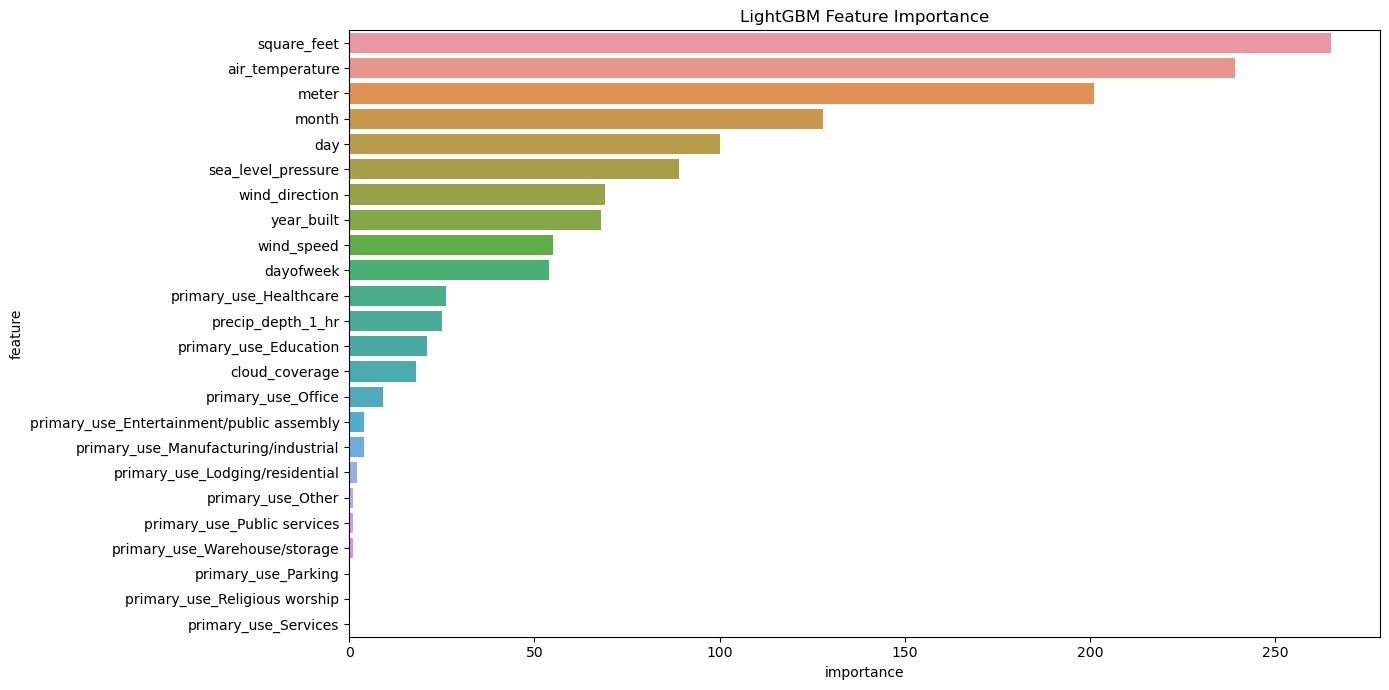

In [136]:
m = LGBMRegressor(learning_rate=1, max_depth=14, n_estimators=46, random_state=0)
m.fit(X_train, y_train)

eval = pd.DataFrame()
eval["feature"] = X.columns.values
eval["importance"] = m.feature_importances_

plt.figure(figsize=(14, 7))
sns.barplot(data=eval.sort_values(by="importance", ascending=False), x="importance", y="feature")
plt.title("LightGBM Feature Importance")
plt.tight_layout()
plt.show()

The most important features are `square_feet`, `air_temperature`, and `meter`.<br>
The least important features are `primary_use`, `precip_depth_1_hr`, and `cloud_coverage`.

[back to table of contents](#back)

### 4.5. Dimensionality Reduction <a id='dev5'></a>

In [137]:
from sklearn.decomposition import PCA

Reduce features dimensionality 24 to 10 dimensions.

In [138]:
pca = PCA(n_components=10)
pca.fit(X_train, y_train)

PCA(n_components=10)

Plot explained variance ratio

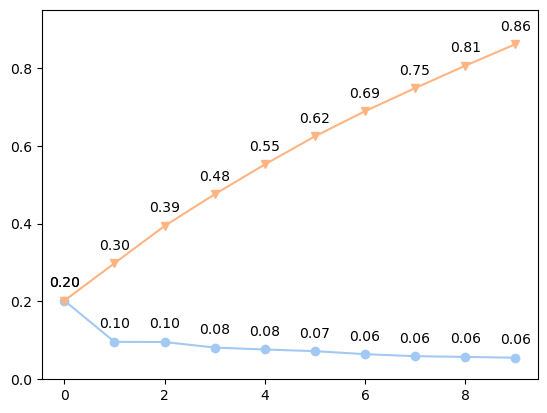

In [139]:
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='v')
for i, ratio in enumerate(pca.explained_variance_ratio_):
    plt.annotate(f'{ratio:.2f}', (i, ratio), textcoords="offset points", xytext=(0,10), ha='center')
for i, ratio in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    plt.annotate(f'{ratio:.2f}', (i, ratio), textcoords="offset points", xytext=(0,10), ha='center')
plt.ylim([0,0.95])
plt.show()

In [140]:
np.cumsum(pca.explained_variance_ratio_)

array([0.20211248, 0.29832392, 0.39405982, 0.47557153, 0.552129  ,
       0.6244561 , 0.68897409, 0.74834939, 0.80590229, 0.86125007])

First feature explain 20% of the variance, second and third features explain 10% variance. It requires 9 dimensions to capture 80% variance in the dataset.

Transform datasets.

In [141]:
X_train_pca = pca.transform(X_train)
X_valid_pca = pca.transform(X_valid)

### 4.6. Build Model with Reduced Features <a id='dev6'></a>

In [142]:
m = LGBMRegressor(learning_rate=1, max_depth=14, n_estimators=46, random_state=0)
m.fit(X_train_pca, y_train)

y_train_pred = m.predict(X_train_pca)
train_rmsle['LGBMRegressor_PCA'] = rmsle(y_train, y_train_pred)

y_valid_pred = m.predict(X_valid_pca)
valid_rmsle['LGBMRegressor_PCA'] = rmsle(y_valid, y_valid_pred)

In [143]:
rmsles = pd.DataFrame([train_rmsle, valid_rmsle], index=['train','valid'])
rmsles.T

train     valid
LGBMRegressor      1.580421  1.614585
LGBMRegressor_PCA  2.193860  2.242804

There is 0.6 difference in RMSLE score between LightGBM with PCA and without PCA.

## 5. General Conclusion <a id='end'></a>

For the preprocessing, the missing data in weather dataset and is imputed using median in each columns grouped by site id as each site has similar characteristics. For the sites without any readings, the data is imputed using overall median. For missing `year_built` data in building dataset, the values are imputed using overall median for the column.

Features used in this research are:
meter, year, month, day, dayofweek, primary_use, square_feet, year_built, air_temperature, cloud_coverage, precip_depth_1_hr, sea_level_pressure, wind_direction, wind_speed.

For the features not used in model training, the feature is either leaking target data or redundant data.

The best model trained in this research is **LightGBM Regressor** with the hyperparameters: **learning_rate = 1.0, max_depth = 14, and n_estimators = 46**. Prediction on **training** dataset has the RMSLE score of **1.580** and prediction on validation dataset has the score of **1.614**. Both scores are considerably low and the fitted model doesn't show overfitting. When trained using **PCA** features, the model has RMSLE of **2.243** which is considerably higher than without PCA.

The most important features for this model are `square_feet`, `air_temperature`, and `meter`. And the least important features are `primary_use`, `precip_depth_1_hr`, and `cloud_coverage`.

[back to table of contents](#back)

## 6. Submission <a id='submit'></a>

To generate submission, it requires ~8GB RAM, which is not available in my local machine or cloud service platform. So, this step is skipped for now.

Load all data in test set.

In [144]:
test = pd.read_csv('datasets/test.csv')

Change `timestamp` to right datatype.

In [145]:
test['timestamp'] = pd.to_datetime(test['timestamp'])

Make features.

In [146]:
make_date_features(test, 'timestamp')

Merge tables.

In [147]:
test = test.merge(building, on='building_id', how='left').merge(weather_test, on=['site_id','timestamp'], how='left')

drop `primary_use` in X for training.

In [148]:
X = train[['meter', 'month', 'day', 'dayofweek', 'square_feet', 'year_built', 'air_temperature', 
           'cloud_coverage', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']]

Select features.

In [149]:
X_test = test[['meter', 'month', 'day', 'dayofweek', 'square_feet', 'year_built', 'air_temperature', 
               'cloud_coverage', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']]

Scale numerical data with MinMaxScaler.

In [150]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

Train.

In [151]:
m = LGBMRegressor(learning_rate=1, max_depth=14, n_estimators=46, random_state=0)
m.fit(X, y)

LGBMRegressor(learning_rate=1, max_depth=14, n_estimators=46, random_state=0)

Predict.

In [152]:
y_pred_test = m.predict(X_test)

Generate submission file.

In [ ]:
submission = pd.DataFrame({"row_id": test['row_id'], "meter_reading": y_pred_test})
submission.to_csv("submission.csv", index=False)

[back to table of contents](#back)